# 1. Introduction & Workflow

This notebook implements a complete shear-wave splitting tomography workflow for Axial Seamount, from raw data to 3D anisotropy structure.

## 1.1 End-to-End Workflow
- **Data**: earthquake catalogs, station metadata, and 3-component waveforms
- **QC**: SNR, rectilinearity, back-azimuth, and windowing to isolate S-phase
- **Measurements**: shear-wave splitting (φ, δt) + splitting intensity (SI)
- **Ray tracing**: isotropic paths through the Axial Seamount velocity model
- **Inversion**: global linear least-squares to recover anisotropy structure

## 1.2 Key Assumptions & Parameterization
- Isotropic ray geometry for building G (weak anisotropy regime)
- Linear parameterization: **m** = [M_c, M_s] where M_c = A cos(2ψ), M_s = A sin(2ψ)
- Outputs: anisotropy strength A and fast direction ψ (degrees)

# 2. Theoretical Background

This section consolidates the theoretical foundations for shear-wave splitting analysis, splitting intensity, and the global inversion formulation.

## 2.1 Shear-Wave Splitting Theory: φ, δt = f(A, ψ, α, L)

**Silver & Chan (1991) decomposition** for a single anisotropic layer:
- Splitting operator S(φ, δt) models birefringence with fast-axis φ and delay time δt
- Inverse approach: construct the operator that removes splitting and minimizes energy off principal axes
- **Linearized relationship**: δt ≈ A·L·|sin(2(α - ψ))|
  - A: anisotropy strength (fractional velocity difference)
  - L: path length through anisotropic medium
  - α: ray azimuth
  - ψ: fast axis orientation

**Teanby (2004) clustering** for robustness:
- Multiple windows yield clusters of (φ, δt)
- Select stable cluster and propagate uncertainties

## 2.2 Splitting Intensity Theory: SI = E_T / (E_R + E_T)

**Chevrot (2000) formulation**:
- SI quantifies transverse energy relative to total horizontal energy in rotated frame
- **Linear observable**: SI ≈ δt·sin(2θ)·sin(2(α - ψ))
  - θ: incidence angle
  - More linearizable than (φ, δt) in weak anisotropy regime
  - Reduces fast-axis ambiguity and improves magnitude constraints

**Practical computation**:
- Rotate to radial-transverse (RT) frame using back-azimuth
- Bandpass filter and apply taper
- Compute energy ratio: SI = E_T / (E_R + E_T) in S-wave window

## 2.3 Global Inversion Formulation: **d** = **G** · **m**

**Forward model** (Nataf, 1986; Chevrot, 2000):
- Stack observations: **d** = [d₁, d₂, ...] from φ, δt, and SI measurements
- Design matrix **G**: built from isotropic ray path lengths L_ij and sensitivity terms
- Model vector per cell: **m** = [M_c, M_s] where M_c = A cos(2ψ), M_s = A sin(2ψ)

**Regularized least-squares**:
- Solve: (G^T W² G + λ² R^T R) **m** = G^T W² **d**
- W: data weights (inverse uncertainties)
- R: regularization matrix (spatial smoothing + damping)
- λ: regularization parameter (L-curve selection)

**Recovery**:
- Anisotropy strength: A = √(M_c² + M_s²)
- Fast direction: ψ = 0.5 · arctan2(M_s, M_c)

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn import Client
import os
import sys
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors

# Add source directory to path for custom modules
sys.path.insert(0, os.path.abspath('../src'))

from axial_velocity_model import AxialVelocityModel
from obs_array import OBSArray
from earthquake_location import RayTracer
from anisotropy_optimizer import AnisotropyOptimizer
import visualization as viz
from global_anisotropy_inversion import GlobalAnisotropyInverter
from splitting_intensity import SplittingIntensityCalculator, batch_calculate_si
from inversion_diagnostics import InversionDiagnostics, create_comprehensive_diagnostics_report
from splitting_functions import *
from get_all_traces import *
from seismic_geometry import *

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


mtspec not available, using ObsPy PPSD method


### 3.2 Data Preparation & Organization
- Parse catalogs, align event-station metadata
- Build extended windows for waveform retrieval
- Persist formatted datasets for reuse

In [2]:
# Parse raw phase pick data and create organized catalog

# Load and parse the raw phase pick data
print("Loading raw phase pick data from Axial Seamount...")

# Parse the phase file
phase_file = '../data/ax.hinv.pha.shots_erup'
events_df, phases_df = parse_phase_file(phase_file)

print(f"\nParsed {len(events_df)} events and {len(phases_df)} phase picks")
print(f"Date range: {events_df['year'].min()}-{events_df['year'].max()}")

# Display sample of parsed data
print(f"\nSample events:")
display(events_df.head())

print(f"\nSample phases:")
display(phases_df.head())

# Create organized catalog structure
raw_catalog = create_organized_catalog(events_df, phases_df)


Loading raw phase pick data from Axial Seamount...
Parsing phase file: ../data/ax.hinv.pha.shots_erup
Processing 2551850 lines...

Parsed 273829 events and 2278021 phase picks
Date range: 2014-2021

Sample events:


event_id  year  month  day  hour  minute  second              datetime_str  \
0   1000000  2014     11    4    20      39   59.02  2014-11-04T20:39:59.020Z   
1   1000001  2014     11    4    20      42   12.47  2014-11-04T20:42:12.470Z   
2   1000002  2014     11    4    20      46    1.97  2014-11-04T20:46:01.970Z   
3   1000003  2014     11    4    20      46   35.13  2014-11-04T20:46:35.130Z   
4   1000004  2014     11    4    20      47    7.00  2014-11-04T20:47:07.000Z   

       lat       lon  depth  magnitude  
0  45.9242 -130.0807   1.10        0.0  
1  45.9398 -130.0170   0.42        0.0  
2  45.9307 -130.0115   0.22        0.0  
3  45.9347 -130.0153   0.54        0.0  
4  45.9303 -130.0117   0.07        0.0


Sample phases:


event_id            event_datetime  event_lat  event_lon  event_depth  \
0   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
1   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
2   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
3   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   
4   1000000  2014-11-04T20:39:59.020Z    45.9242  -130.0807          1.1   

   event_magnitude  station  arrival_time  weight phase_type quality  
0              0.0  OOAXAS2          1.42     NaN          P      EH  
1              0.0  OOAXAS2          1.93     NaN          S      EH  
2              0.0  OOAXEC3          1.29    -0.5          P      EH  
3              0.0  OOAXEC3          2.46    -0.2          S      EH  
4              0.0  OOAXEC2          0.68     0.5          P      HH

Creating organized catalog with events × stations structure...
Events: 273829, Stations: 7
Stations in network: ['OOAXAS1', 'OOAXAS2', 'OOAXCC1', 'OOAXEC1', 'OOAXEC2', 'OOAXEC3', 'OOAXID1']
Total event-station pairs: 1916803
Pairs with both P and S picks: 982168


TypeError: object of type 'NoneType' has no len()

In [3]:
print(f"\nOrganized catalog created with {len(raw_catalog)} event-station pairs")
print(f"Events: {raw_catalog['id'].nunique()}, Stations: {raw_catalog['station'].nunique()}")

# Display sample of organized catalog
print(f"\nSample of organized catalog:")
display(raw_catalog.head())

TypeError: object of type 'NoneType' has no len()

In [9]:
# Load earthquake catalog
catalog = pd.read_csv('../data/2018_eq_catalog.csv')

# Edit catalog to only include data from June - Dec 2015
# Also remove unnecessary columns: total_picks, p_weight, p_quality, s_weight, s_quality, and index
start_date = UTCDateTime("2015-06-01T00:00:00")
end_date = UTCDateTime("2015-12-31T23:59:59")
edited_catalog = catalog[(catalog['datetime'] >= start_date) & (catalog['datetime'] <= end_date)].copy()
#edited_catalog = edited_catalog.drop(columns=['total_picks', 'p_weight', 
#                                              'p_quality', 's_weight', 's_quality'])

edited_catalog.reset_index(drop=True, inplace=True)

KeyboardInterrupt: 

In [ ]:
# Use the organized catalog created from raw phase picks
print("Using organized catalog created from raw phase pick data...")

# Set catalog as our working dataset
catalog = edited_catalog.copy()

print(f"Working catalog has {len(catalog)} event-station pairs")
print(f"Date range: {catalog['datetime'].min()} to {catalog['datetime'].max()}")

# Display basic catalog info
print("\nCatalog columns:", catalog.columns.tolist())
print("\nFirst few events:")
display(catalog.head())


Using organized catalog created from raw phase pick data...
Working catalog has 12635 event-station pairs
Date range: 2015-06-01T00:35:49.610Z to 2015-12-31T21:35:41.950Z

Catalog columns: ['Unnamed: 0', 'id', 'year', 'datetime', 'lat', 'lon', 'dep', 'mag', 'station', 'p_arrival_time', 's_arrival_time']

First few events:


Unnamed: 0       id  year                  datetime      lat       lon  \
0      536619  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
1      536620  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
2      536621  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
3      536622  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   
4      536623  1172862  2015  2015-06-01T00:35:49.610Z  45.9447 -129.9855   

    dep  mag  station  p_arrival_time  s_arrival_time  
0  0.59  0.0  OOAXEC3            0.42            0.93  
1  0.59  0.0  OOAXEC2            0.40            0.97  
2  0.59  0.0  OOAXAS1            0.56            1.19  
3  0.59  0.0  OOAXCC1            0.62            1.37  
4  0.59  0.0  OOAXEC1            0.34            0.75

In [ ]:
# Save formatted catalog to csv
catalog.to_csv('../data/2015_jun_dec_eq_catalog.csv')

In [2]:
# Load earthquake catalog
catalog = pd.read_csv('../data/2015_jun_dec_eq_catalog.csv')
# Load station information
stations_file = '../data/axial_seamount_stations.csv'
stations_df = pd.read_csv(stations_file)

print(f"Stations in catalog: {catalog['station'].value_counts()}")

Stations in catalog: station
OOAXEC3    2653
OOAXEC1    2280
OOAXCC1    2050
OOAXEC2    1944
OOAXAS1    1829
OOAXAS2    1181
OOAXID1     698
Name: count, dtype: int64


### 3.3 Waveform Retrieval
- Download or read local 3C waveforms
- Organize by event and station
- Track retrieval diagnostics

In [3]:
# Create extended time windows for proper waveform analysis
print("Creating extended time windows for waveform retrieval...")

# Apply extended windowing
extended_catalog = create_extended_catalog(catalog, pre_event_time=4.0, post_event_time=15.0)

print(f"Extended catalog created with {len(extended_catalog)} events")
print(f"Time windows: {extended_catalog['total_duration'].iloc[0]} seconds total")
print(f"Pre-event: {extended_catalog['pre_event_sec'].iloc[0]}s, Post-event: {extended_catalog['post_event_sec'].iloc[0]}s")

# Display sample of extended timing
print("\nSample timing windows:")
sample_cols = ['id', 'datetime', 'starttime', 'endtime', 'total_duration']
display(extended_catalog[sample_cols].head())

Creating extended time windows for waveform retrieval...
Extended catalog created with 12635 events
Time windows: 19.0 seconds total
Pre-event: 4.0s, Post-event: 15.0s

Sample timing windows:


id                  datetime                    starttime  \
0  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
1  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
2  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
3  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   
4  1172862  2015-06-01T00:35:49.610Z  2015-06-01T00:35:45.610000Z   

                       endtime  total_duration  
0  2015-06-01T00:36:04.610000Z            19.0  
1  2015-06-01T00:36:04.610000Z            19.0  
2  2015-06-01T00:36:04.610000Z            19.0  
3  2015-06-01T00:36:04.610000Z            19.0  
4  2015-06-01T00:36:04.610000Z            19.0

## 3. Data & Inputs

This section covers data preparation, waveform retrieval, and quality control for splitting analysis.

### 3.1 Data Sources
- Earthquake catalogs and time windows
- Station metadata and coordinates
- Waveform files and organization

In [4]:

# Filter for stations AXAS1, AXCC1, AXEC2, and AXID1
filtered_catalog = extended_catalog[
    (extended_catalog['station'] == 'OOAXAS1') | 
    (extended_catalog['station'] == 'OOAXCC1') | 
    (extended_catalog['station'] == 'OOAXEC2') | 
    (extended_catalog['station'] == 'OOAXID1') ].copy()

print(f"Filtered catalog has {len(filtered_catalog)} events for stations AXAS1, AXCC1, AXEC2, and AXID1")

# Keep the first 100 events
print("Keeping the first 100 events for testing...")
test_catalog = filtered_catalog.head(100).copy()

# Remove leading 'OO' from station names
test_catalog['station'] = test_catalog['station'].str.replace('OO', '', regex=False)

Filtered catalog has 6521 events for stations AXAS1, AXCC1, AXEC2, and AXID1
Keeping the first 100 events for testing...


### 3.4 Quality Control (QC)
- SNR, rectilinearity, and incidence-angle checks
- Back-azimuth calculation and coordinate rotation
- Windowing decisions for S-phase analysis

In [5]:
# Retrieve waveforms for all events in the test catalog using get_all_traces function
print("Retrieving waveforms for all events in the test catalog...")
waveforms = get_station_traces(test_catalog, 'first_event', 'starttime', 'endtime', 'station')

Retrieving waveforms for all events in the test catalog...
Retrieved data for AXEC2 HHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHZ from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXAS1 EHZ from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXCC1 HHE from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXCC1 HHN from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXCC1 HHZ from 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
Retrieved data for AXEC2 HHE from 2015-06-01T00:44:46.590000Z to 2015-06-01T00:45:05.590000Z
Retrieved d

In [6]:
# Associate waveforms with events in the catalog
print("Organizing waveforms by events...")
waveform_dict = organize_stream_by_events(waveforms, test_catalog)

Organizing waveforms by events...
Organizing stream data for 100 events...
  Event 1: Found 3 traces for AXEC2 at 2015-06-01T00:35:49.610000Z
  Event 2: Found 3 traces for AXAS1 at 2015-06-01T00:35:49.610000Z
  Event 3: Found 3 traces for AXCC1 at 2015-06-01T00:35:49.610000Z
  Event 4: Found 3 traces for AXEC2 at 2015-06-01T00:44:50.590000Z
  Event 5: Found 3 traces for AXCC1 at 2015-06-01T00:44:50.590000Z
  Event 6: Found 3 traces for AXCC1 at 2015-06-01T04:27:35.690000Z
  Event 7: Found 3 traces for AXAS1 at 2015-06-01T04:34:14.540000Z
  Event 8: Found 3 traces for AXCC1 at 2015-06-01T04:34:14.540000Z
  Event 9: Found 3 traces for AXAS1 at 2015-06-01T04:52:10.190000Z
  Event 10: Found 3 traces for AXCC1 at 2015-06-01T04:52:10.190000Z
  Event 11: Found 3 traces for AXCC1 at 2015-06-01T05:08:11.970000Z
  Event 12: Found 3 traces for AXEC2 at 2015-06-01T07:36:43.960000Z
  Event 13: Found 3 traces for AXAS1 at 2015-06-01T08:02:26.880000Z
  Event 14: Found 3 traces for AXEC2 at 2015-06-01

In [7]:
# Replace catalog id with index
test_catalog['id'] = test_catalog.index

In [8]:
# Organize waveforms by event ID
print("Organizing waveforms by event ID...")
organized_waveforms = organize_waveform_data(waveform_dict, test_catalog)

Organizing waveforms by event ID...


## 4. Shear-Wave Splitting Analysis

Apply Silver & Chan (1991) method with Teanby (2004) clustering to estimate φ and δt.

- Run SWSPy on quality-controlled waveforms
- Apply clustering and uncertainty propagation
- Compile results to a unified dataframe

In [9]:
# Define quality control thresholds
QC_THRESHOLDS = {
    'min_snr': 2.0,           # Minimum S-wave signal-to-noise ratio
    'min_rectilinearity': 0.7, # Minimum P-wave rectilinearity
    'max_incidence': 30.0,     # Maximum incidence angle (degrees)
    'min_magnitude': 0.0,      # Minimum event magnitude
}

print("Quality control functions loaded successfully")
print(f"QC Thresholds: {QC_THRESHOLDS}")

Quality control functions loaded successfully
QC Thresholds: {'min_snr': 2.0, 'min_rectilinearity': 0.7, 'max_incidence': 30.0, 'min_magnitude': 0.0}


In [10]:
# Calculate quality control metrics for organized waveforms
print("Calculating quality control metrics for organized waveforms...")

# 1. Calculate S-wave SNR
organized_waveforms = calculate_snr_for_organized_waveforms(organized_waveforms)

# 2. Calculate geographic back-azimuth, for coordinate rotation later
organized_waveforms = calculate_back_azimuth_for_organized_waveforms(organized_waveforms, stations_df)

# 3. Calculate P-wave rectilinearity and incidence angle
organized_waveforms = calculate_p_wave_metrics_for_organized_waveforms(organized_waveforms)

Calculating quality control metrics for organized waveforms...
Calculating SNR for 100 events in organized_waveforms...

Processing event 1...
  Found 3 traces for this event

  Calculating SNR for E component:
  S-pick time: 2015-06-01T00:35:50.580000Z
  S-P delay: 0.57s
  Found E trace: 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
  Noise window: 2015-06-01T00:35:50.295000Z to 2015-06-01T00:35:50.580000Z (0.28s)
  Signal window: 2015-06-01T00:35:50.580000Z to 2015-06-01T00:35:50.780000Z (0.20s)
  Noise data points: 58
  Signal data points: 41
  Noise RMS: 20.832995
  Signal RMS: 31.270085
  SNR: 1.50

  Calculating SNR for N component:
  S-pick time: 2015-06-01T00:35:50.580000Z
  S-P delay: 0.57s
  Found N trace: 2015-06-01T00:35:45.610000Z to 2015-06-01T00:36:04.610000Z
  Noise window: 2015-06-01T00:35:50.295000Z to 2015-06-01T00:35:50.580000Z (0.28s)
  Signal window: 2015-06-01T00:35:50.580000Z to 2015-06-01T00:35:50.780000Z (0.20s)
  Noise data points: 58
  Signal da

In [11]:
# Use quality control metrics to filter waveforms
print("Applying quality control filters to waveforms...")
passing_waveforms = apply_quality_control(organized_waveforms, QC_THRESHOLDS)

Applying quality control filters to waveforms...

Applying Quality Control Filters
Initial events: 100

QC Thresholds:
  Minimum SNR: 2.0
  Minimum Rectilinearity: 0.7
  Maximum Incidence: 30.0°
  Minimum Magnitude: 0.0

Checking Individual Events
✗ Event 1: FAIL - SNR too low (1.63 < 2.0)
✗ Event 2: FAIL - SNR too low (1.73 < 2.0), Rectilinearity too low (0.663 < 0.7), Incidence too high (86.3° > 30.0°)
✗ Event 3: FAIL - SNR too low (1.87 < 2.0), Incidence too high (33.2° > 30.0°)
✗ Event 6: FAIL - Incidence too high (77.3° > 30.0°)
✗ Event 7: FAIL - SNR too low (1.91 < 2.0), Incidence too high (43.8° > 30.0°)
✗ Event 12: FAIL - Incidence too high (84.9° > 30.0°)
✗ Event 15: FAIL - SNR too low (1.61 < 2.0), Rectilinearity too low (0.646 < 0.7), Incidence too high (56.6° > 30.0°)
✗ Event 16: FAIL - Incidence too high (72.0° > 30.0°)
✗ Event 18: FAIL - Rectilinearity too low (0.476 < 0.7), Incidence too high (61.0° > 30.0°)
✗ Event 19: FAIL - Incidence too high (33.6° > 30.0°)
✓ Event 2

## 6. Velocity Model & Ray Tracing

Build the isotropic Axial Seamount velocity model and initialize ray tracer.

- Create 3D velocity grid with geological features (caldera, magma chamber)
- Initialize PyKonal-based ray tracer for computing path lengths
- Use local Cartesian coordinates aligned to station/event geometry

Performing shear-wave splitting analysis using SWSPy...

Performing Shear-Wave Splitting Analysis
Processing 10 QC-filtered events...

────────────────────────────────────────────────────────────
Event 22
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 112.56°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 3.78
  Rectilinearity: 0.967
  Incidence: 22.0°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz
  Creating SWSPy splitting object...
    Station: AXCC1
    Back-azimuth: 112.56°
  

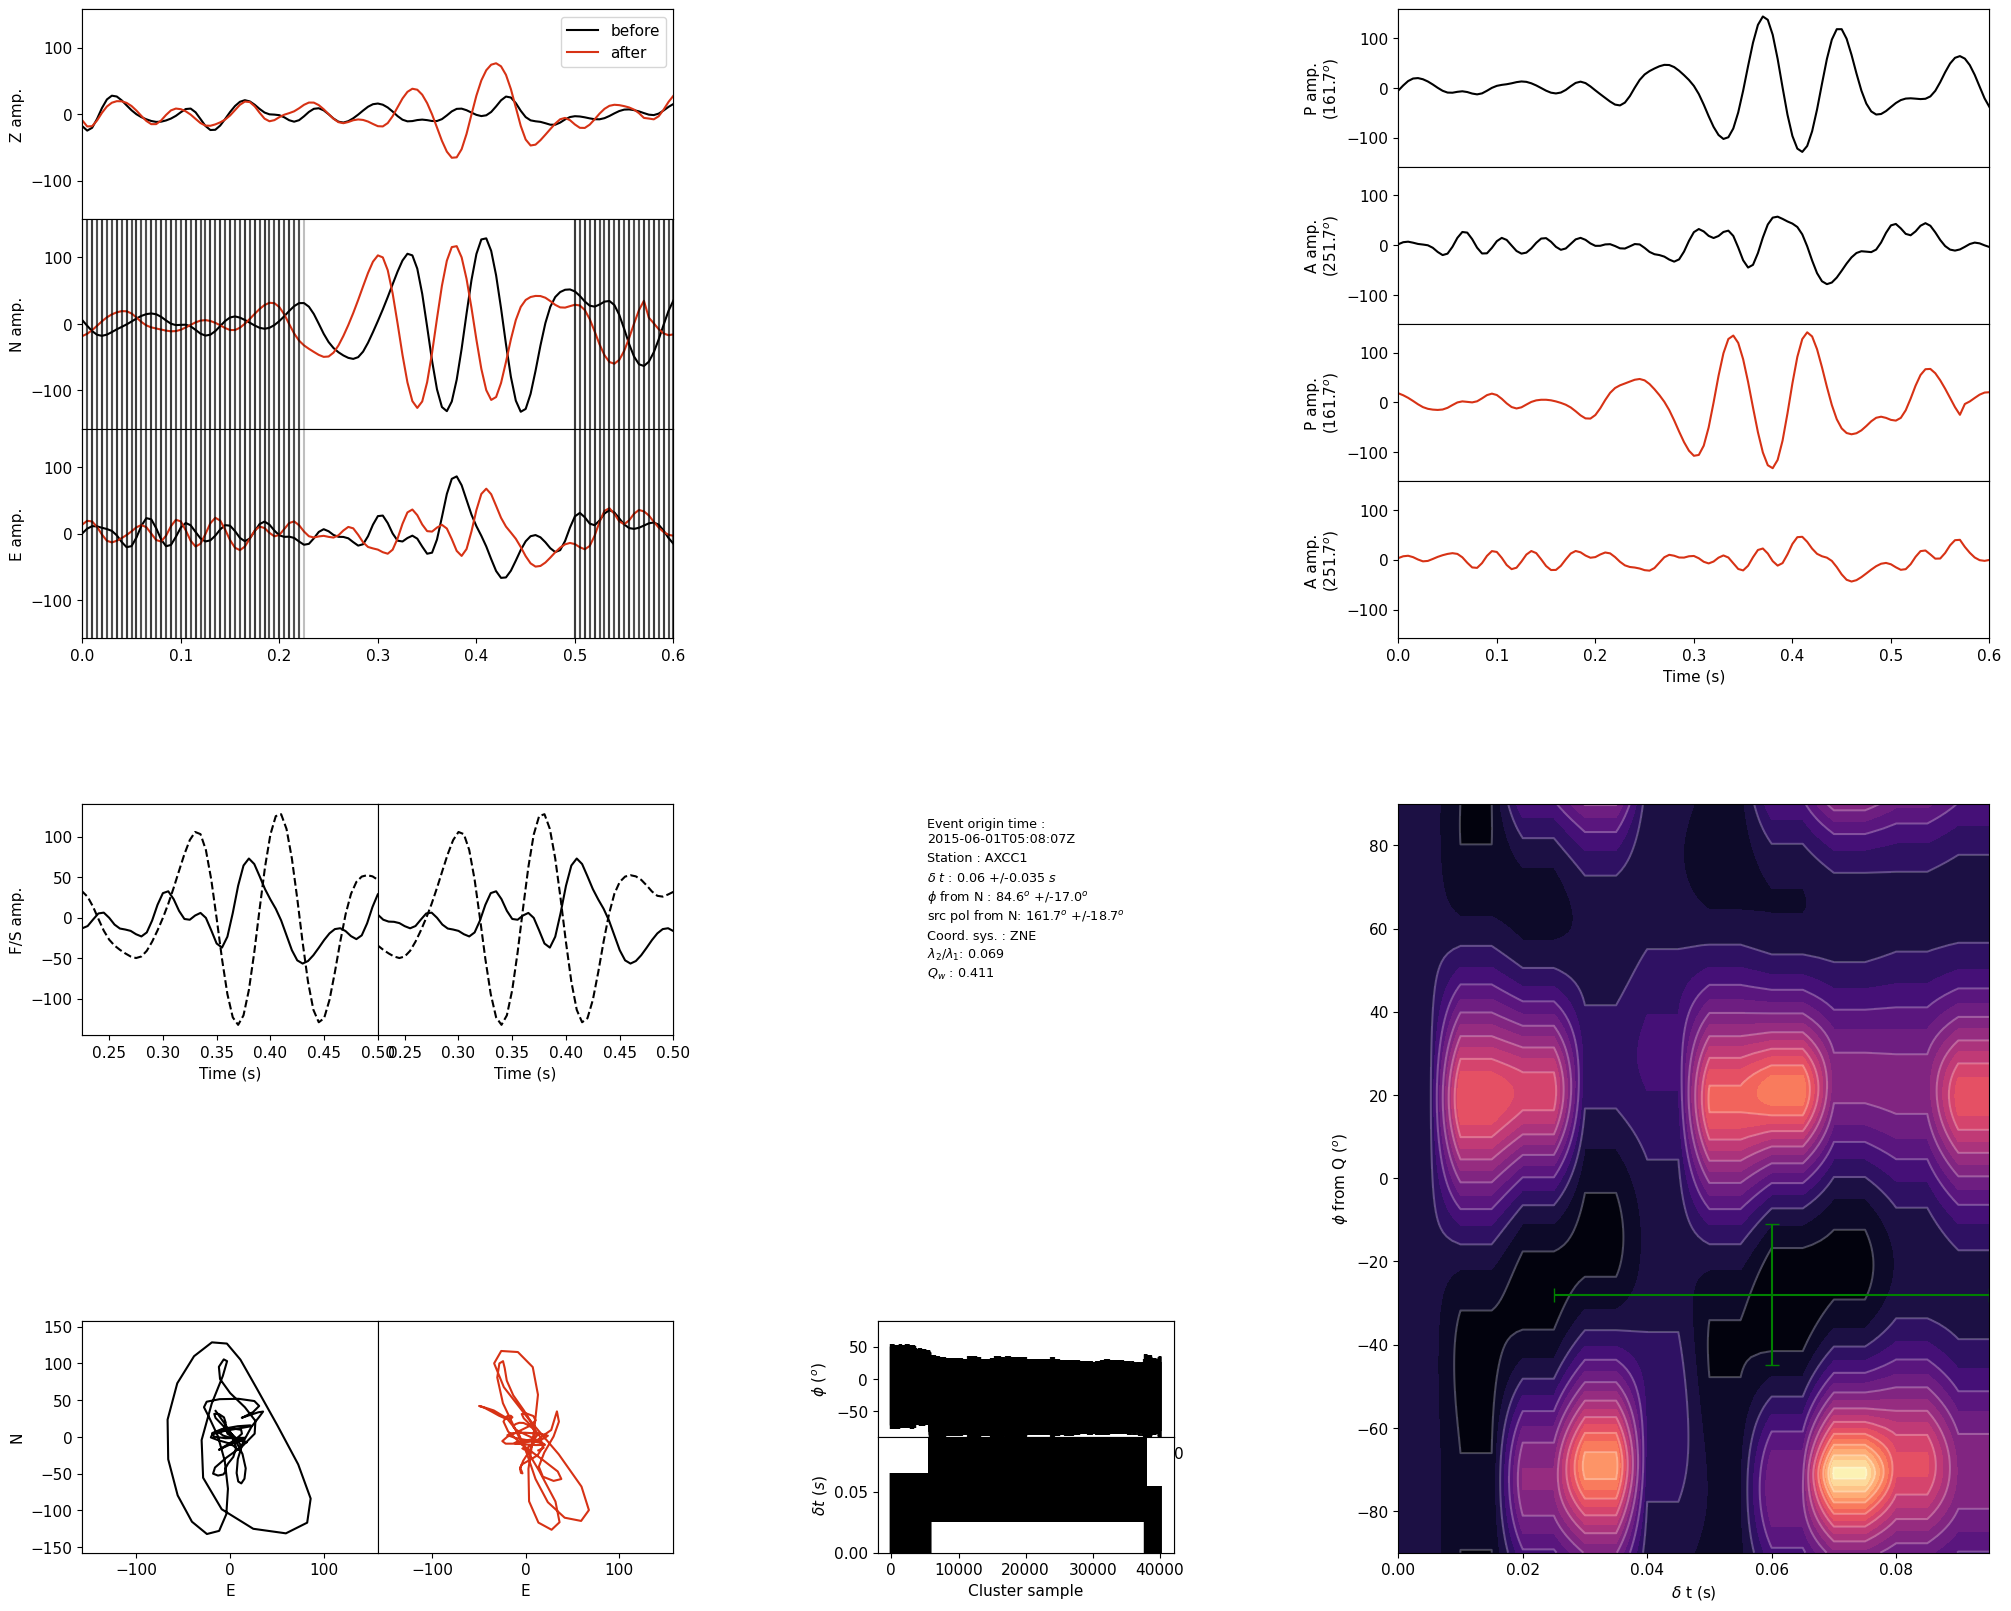

  ✓ Splitting analysis complete!
    Fast axis (φ): 84.6°
    Delay time (δt): 0.060s
  ✓ SUCCESS!
    Fast axis (φ): 84.6°
    Delay time (δt): 0.060s
    φ error: ±17.0°
    δt error: ±0.035s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 41
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 156.11°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 3.02
  Rectilinearity: 0.800
  Incidence: 22.8°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

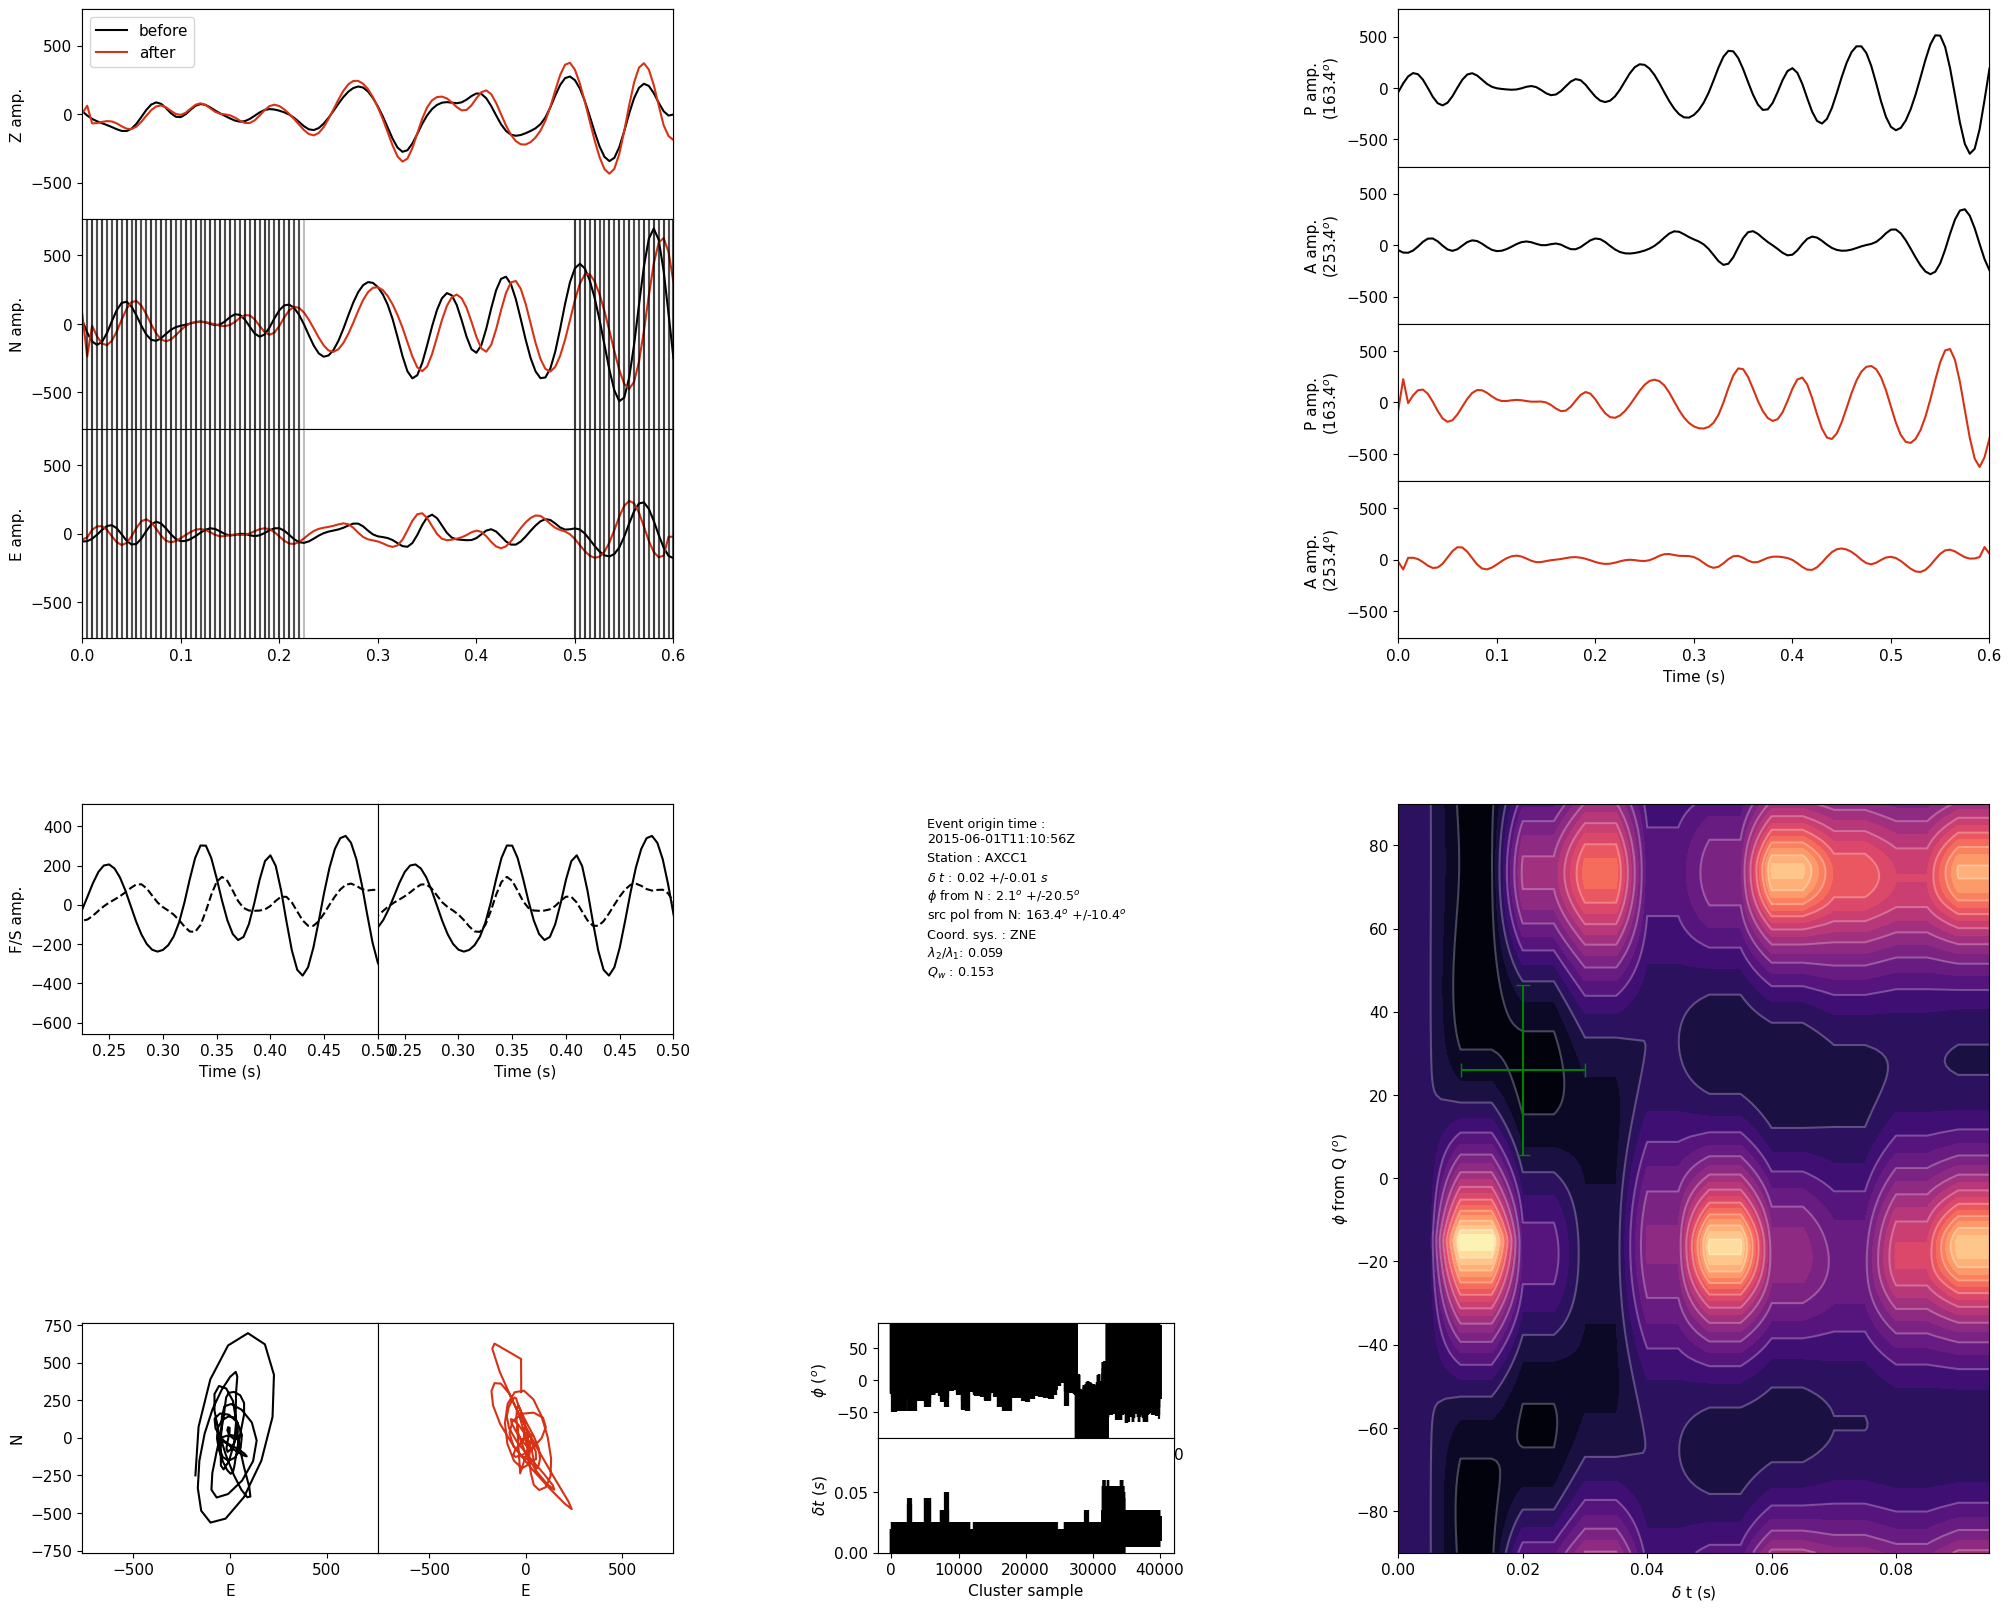

  ✓ Splitting analysis complete!
    Fast axis (φ): 2.1°
    Delay time (δt): 0.020s
  ✓ SUCCESS!
    Fast axis (φ): 2.1°
    Delay time (δt): 0.020s
    φ error: ±20.5°
    δt error: ±0.010s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 45
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 70.63°
  Station: AXAS1
  Magnitude: 0.0
  SNR: 2.38
  Rectilinearity: 0.929
  Incidence: 18.1°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz

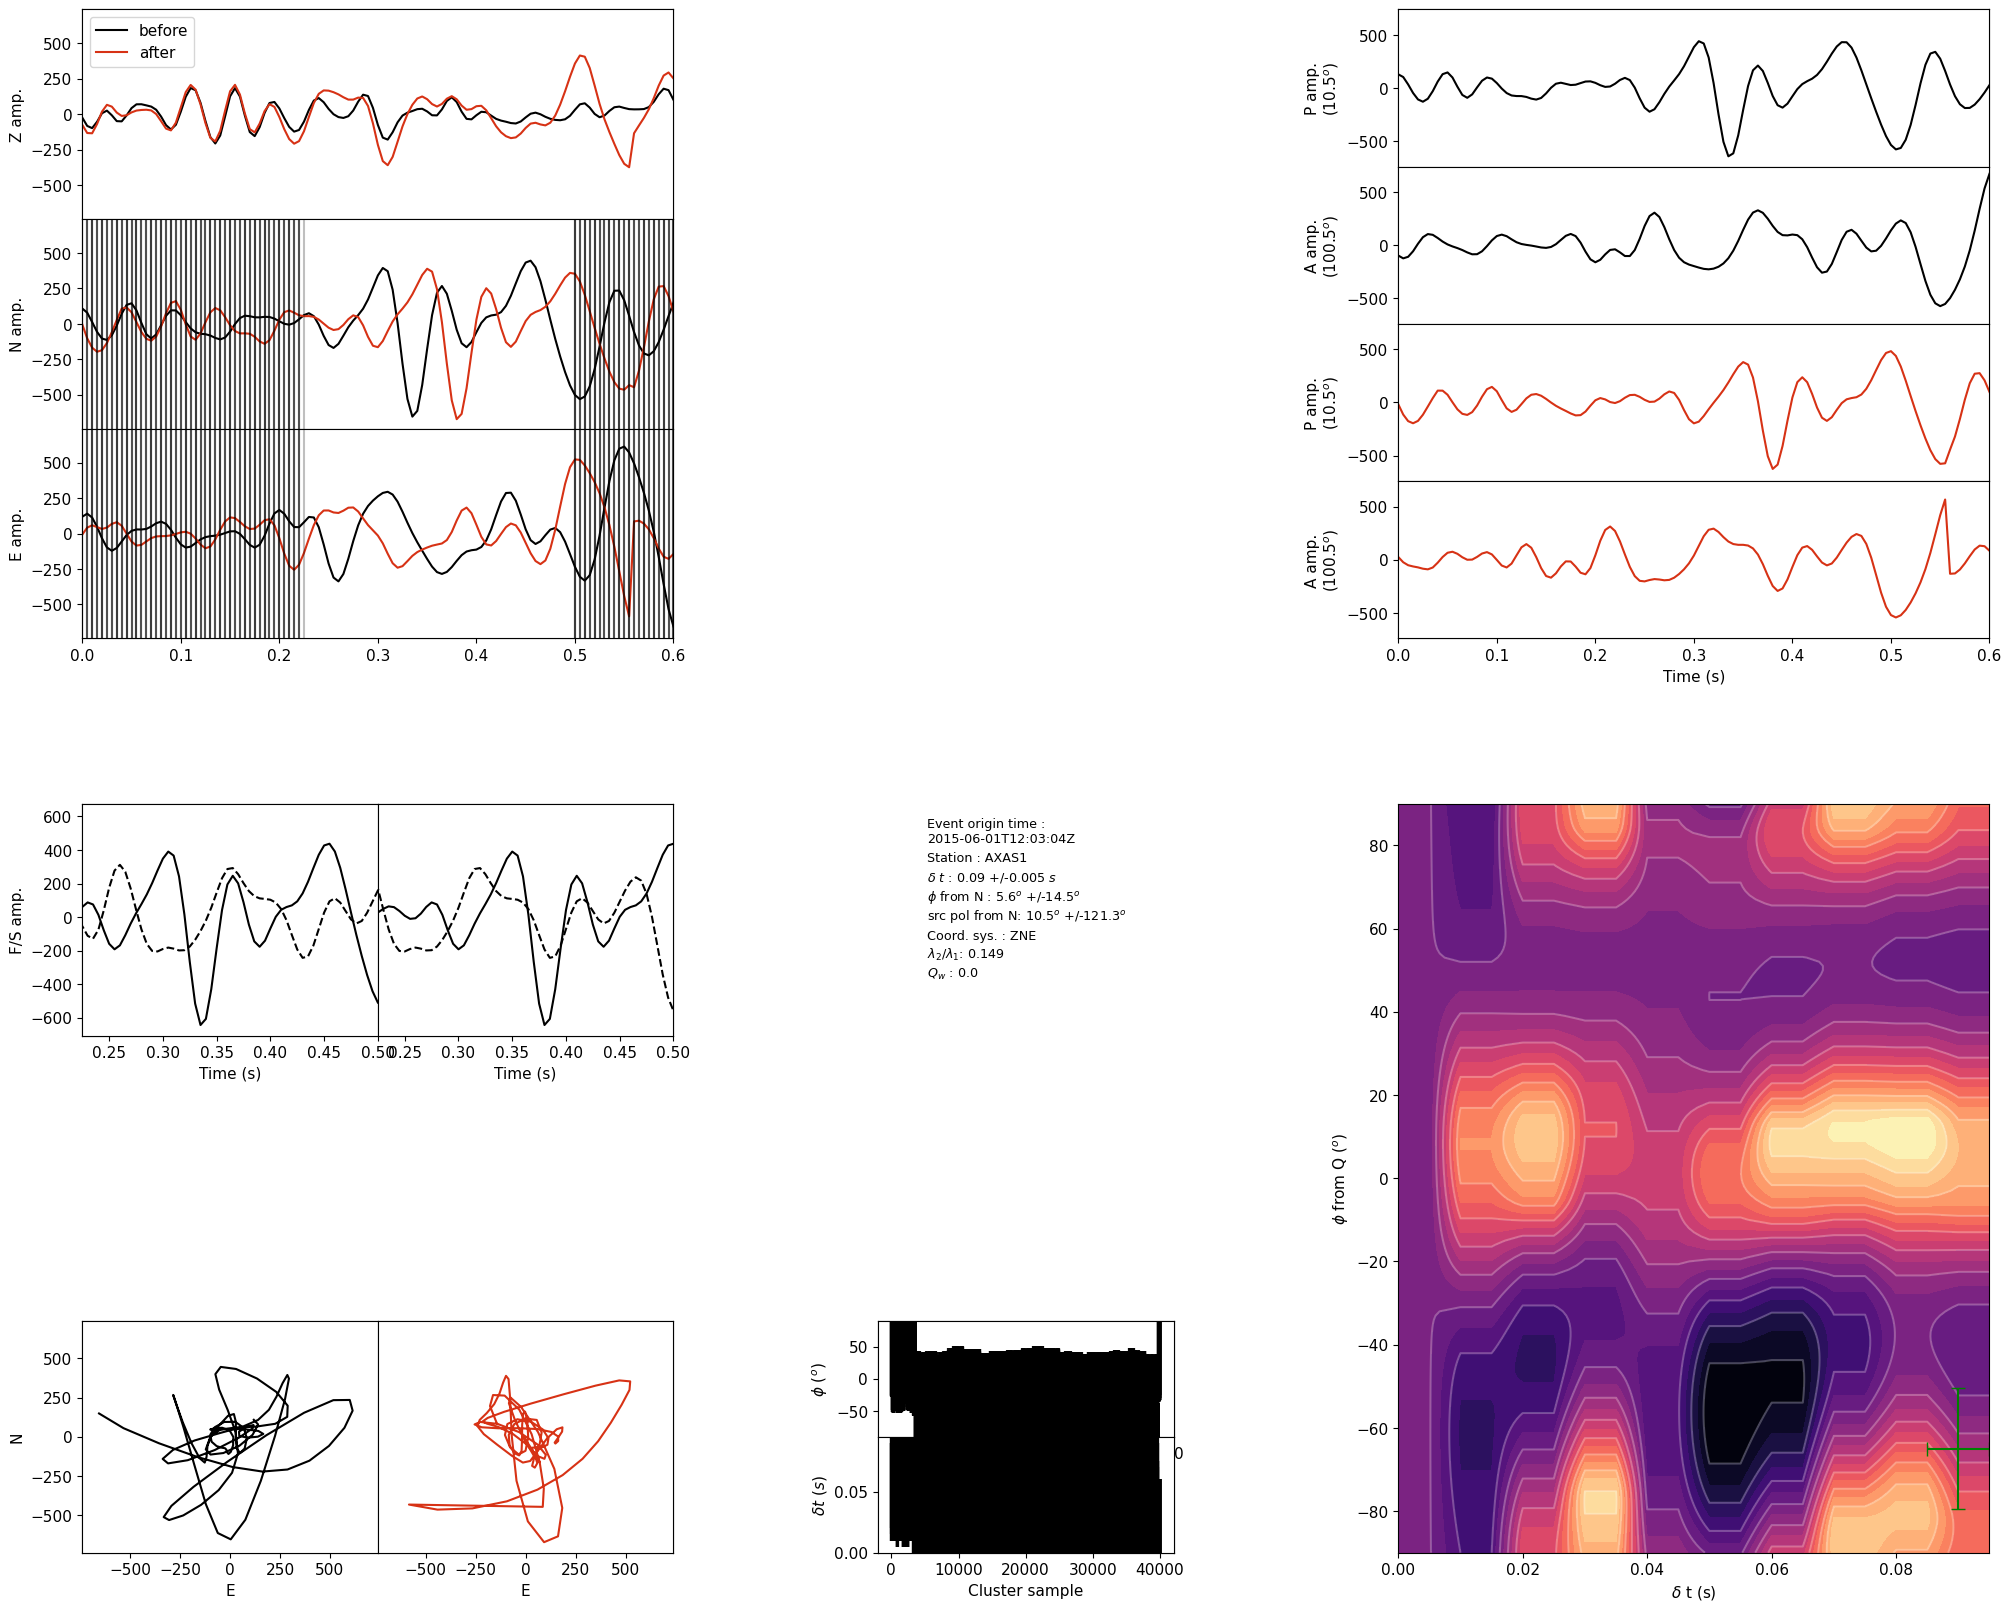

  ✓ Splitting analysis complete!
    Fast axis (φ): 5.6°
    Delay time (δt): 0.090s
  ✓ SUCCESS!
    Fast axis (φ): 5.6°
    Delay time (δt): 0.090s
    φ error: ±14.5°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 52
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 94.98°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 4.94
  Rectilinearity: 0.982
  Incidence: 11.8°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 Hz

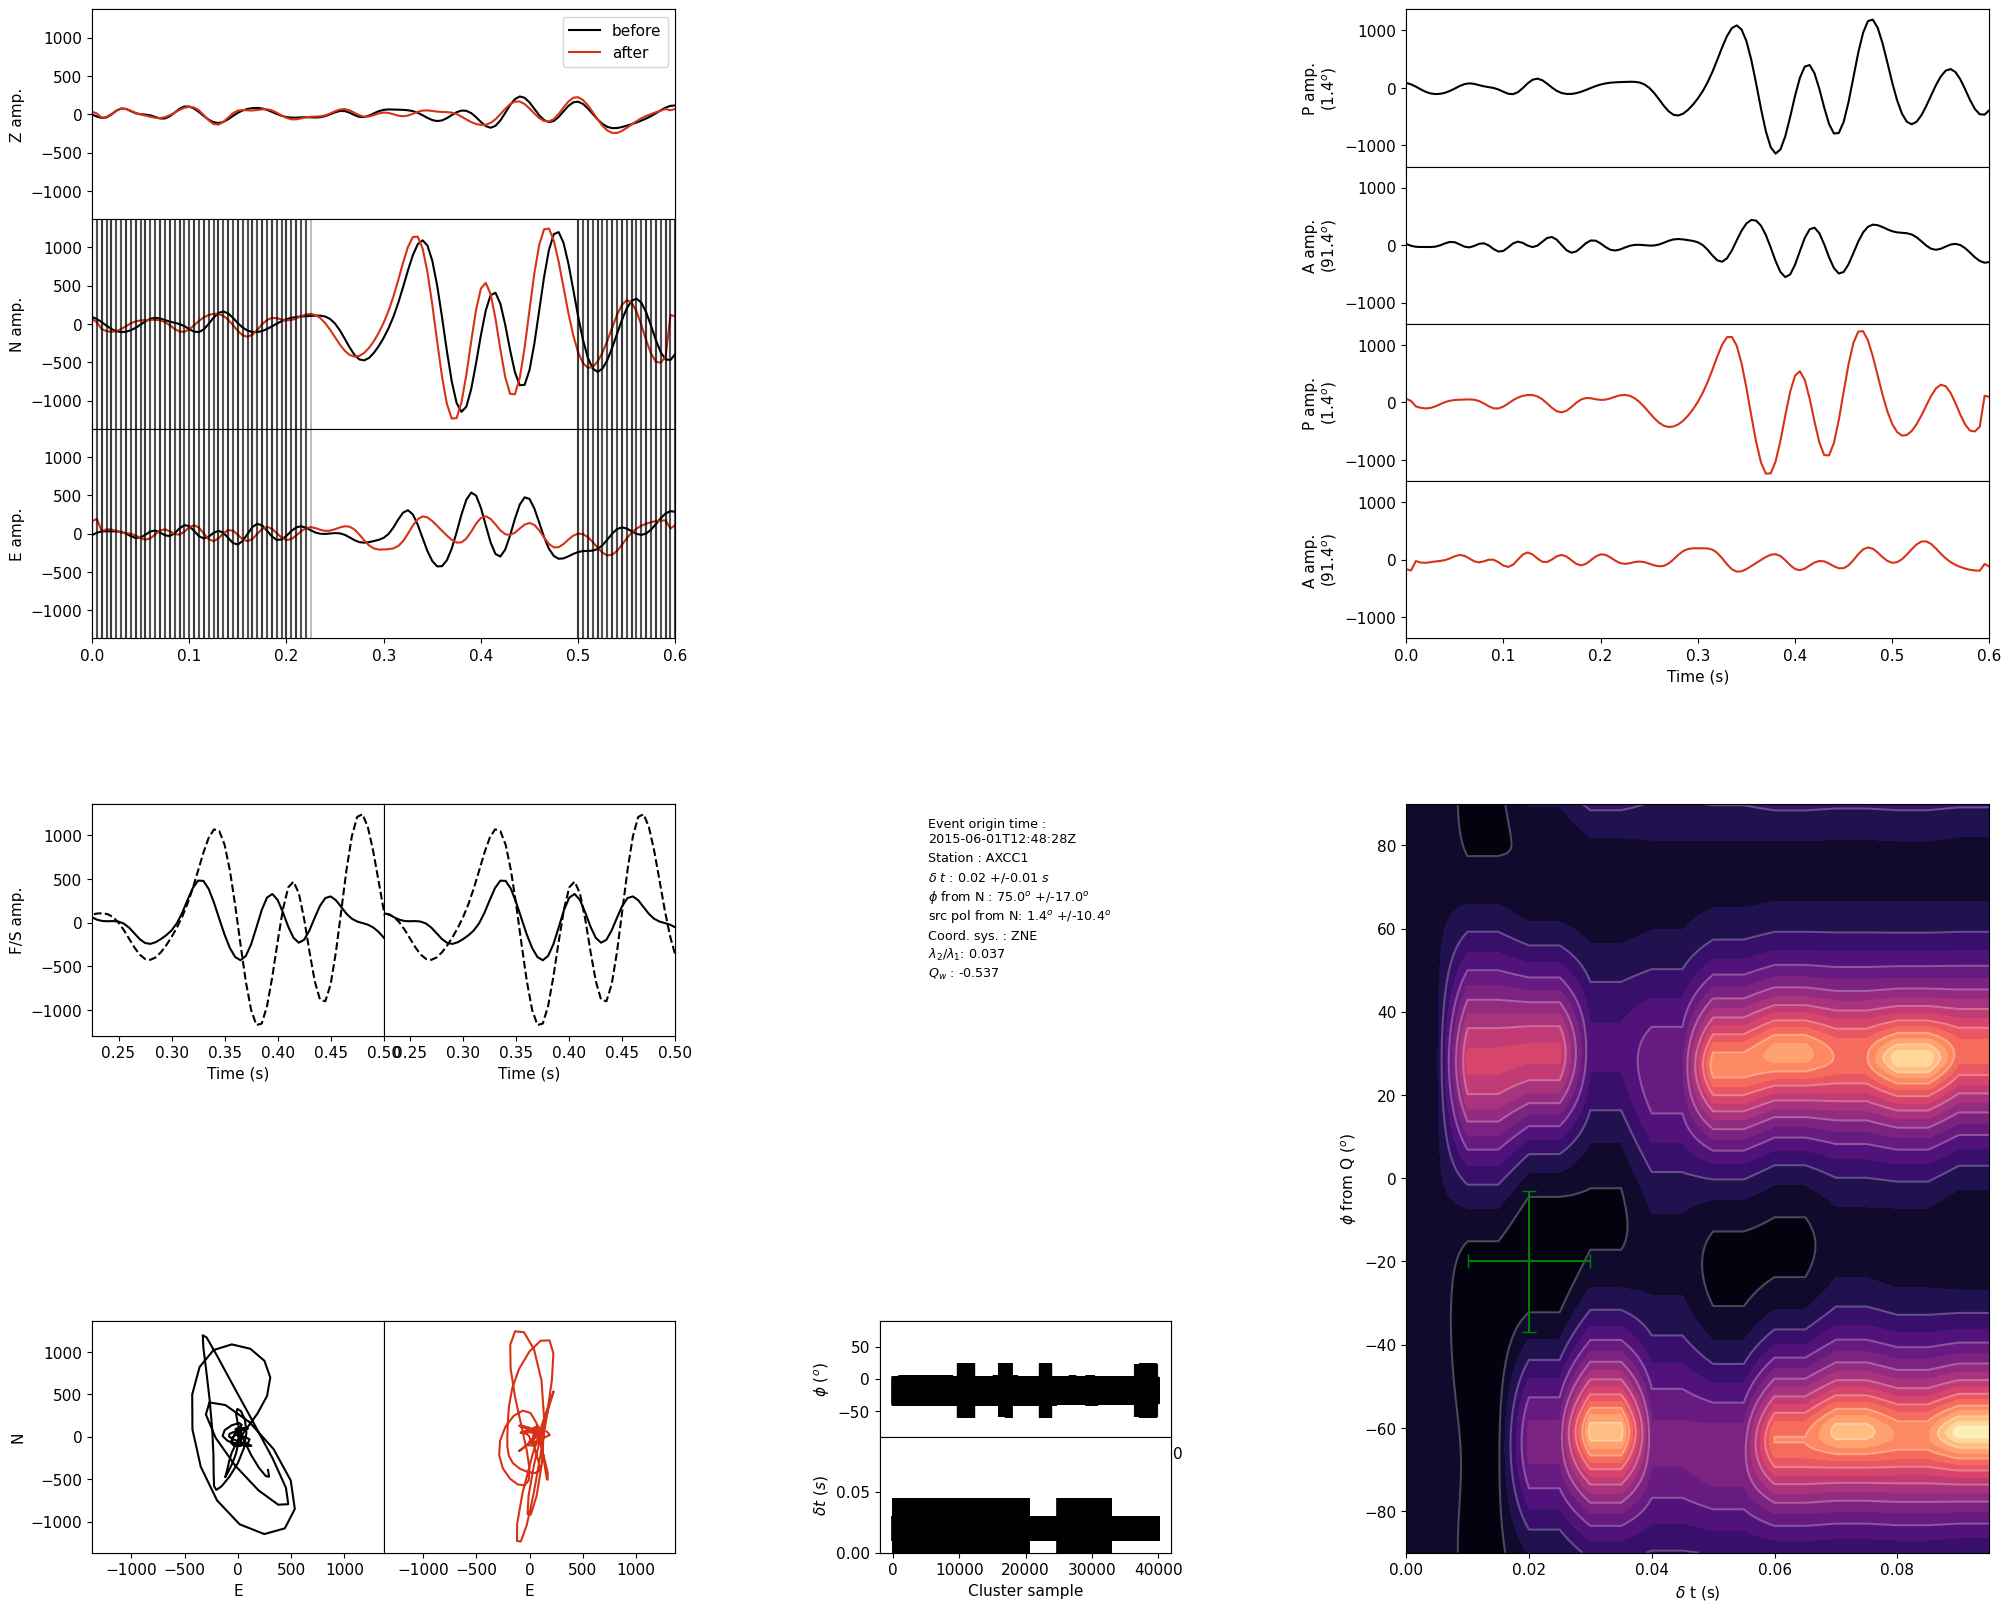

  ✓ Splitting analysis complete!
    Fast axis (φ): 75.0°
    Delay time (δt): 0.020s
  ✓ SUCCESS!
    Fast axis (φ): 75.0°
    Delay time (δt): 0.020s
    φ error: ±17.0°
    δt error: ±0.010s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 121
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 109.77°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.90
  Rectilinearity: 0.979
  Incidence: 14.0°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.

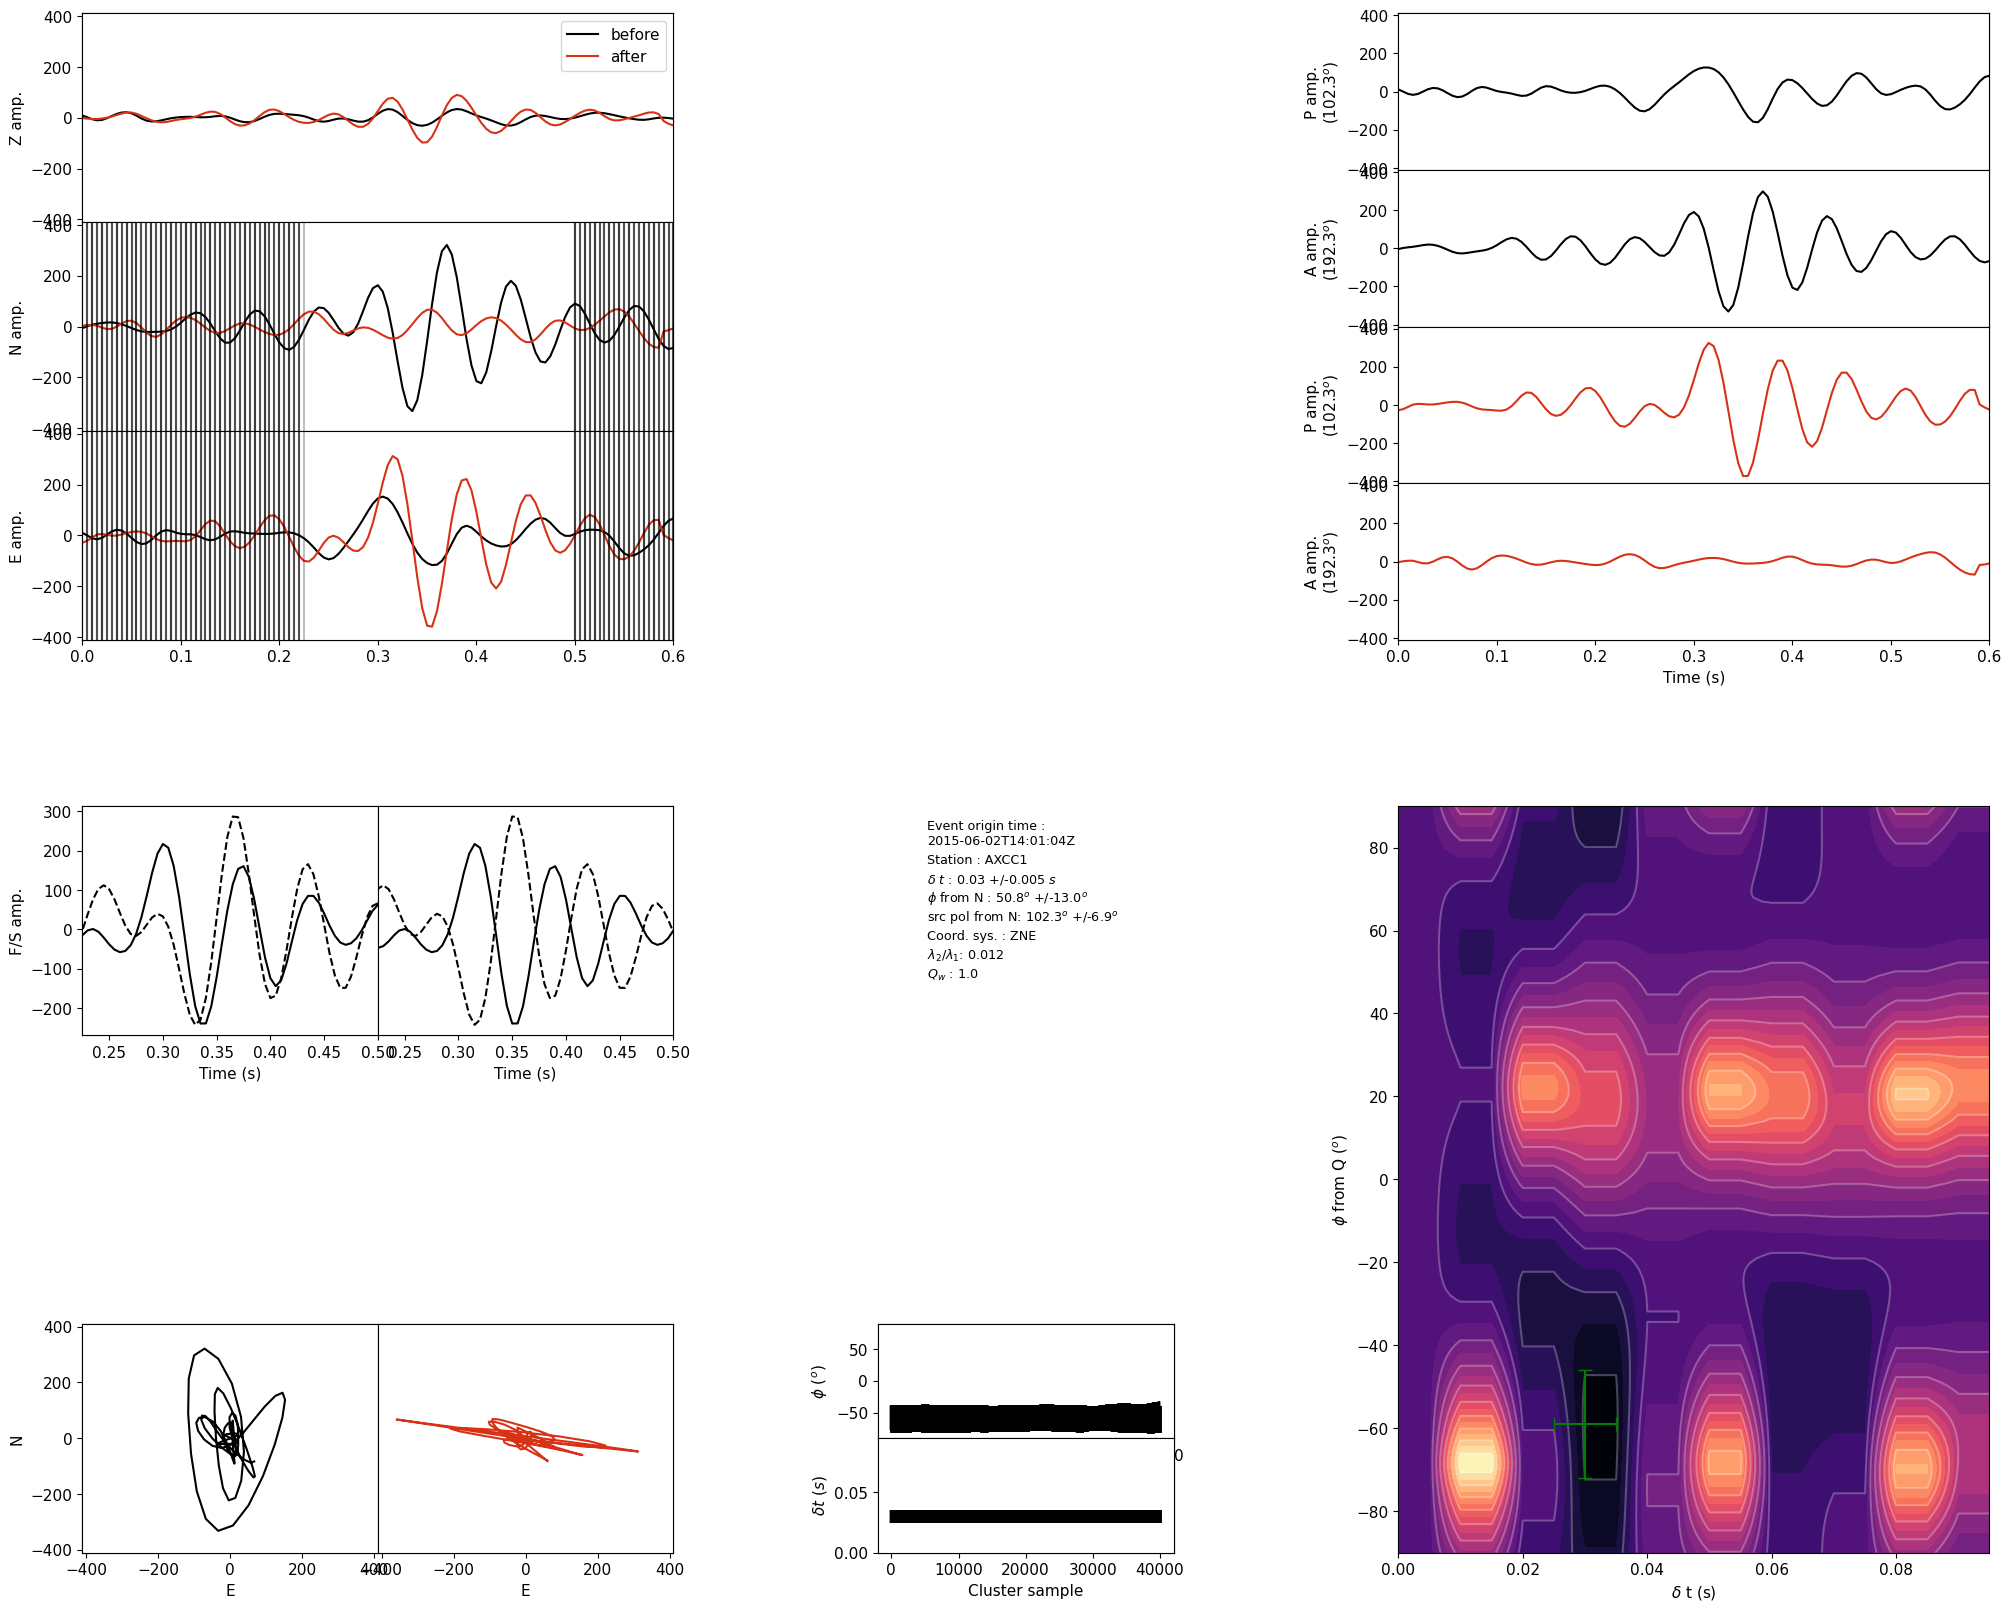

  ✓ Splitting analysis complete!
    Fast axis (φ): 50.8°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): 50.8°
    Delay time (δt): 0.030s
    φ error: ±13.0°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 147
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 109.84°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.65
  Rectilinearity: 0.995
  Incidence: 6.6°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

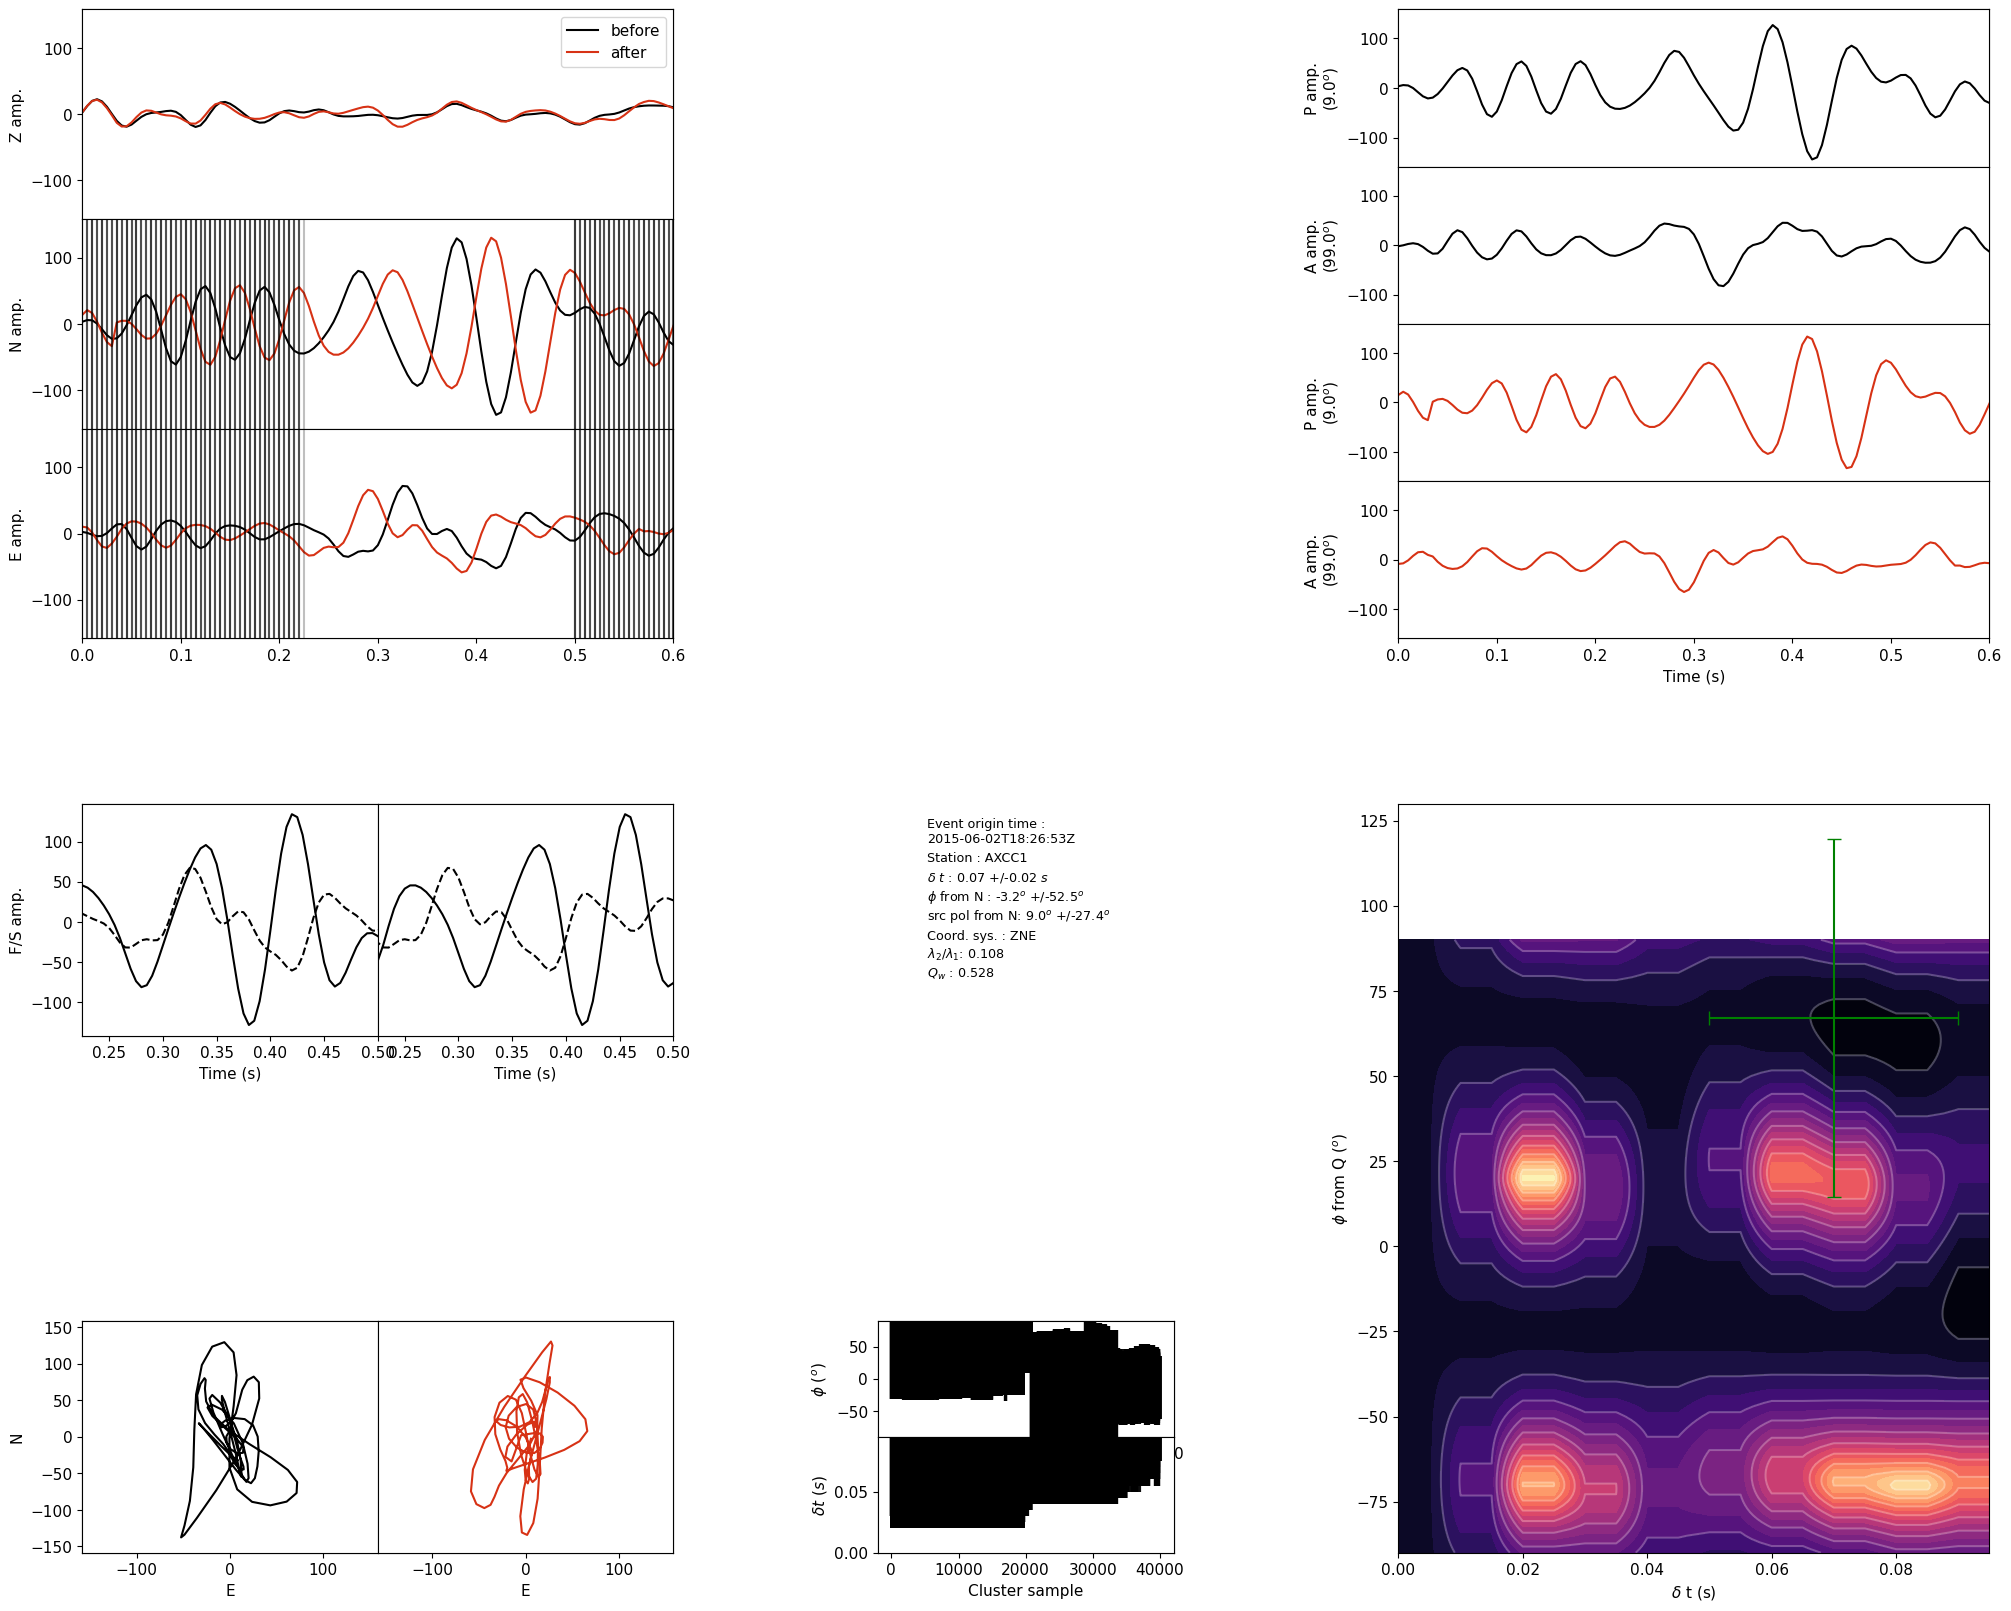

  ✓ Splitting analysis complete!
    Fast axis (φ): -3.2°
    Delay time (δt): 0.070s
  ✓ SUCCESS!
    Fast axis (φ): -3.2°
    Delay time (δt): 0.070s
    φ error: ±52.5°
    δt error: ±0.020s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 149
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 133.87°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.67
  Rectilinearity: 0.947
  Incidence: 28.3°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.

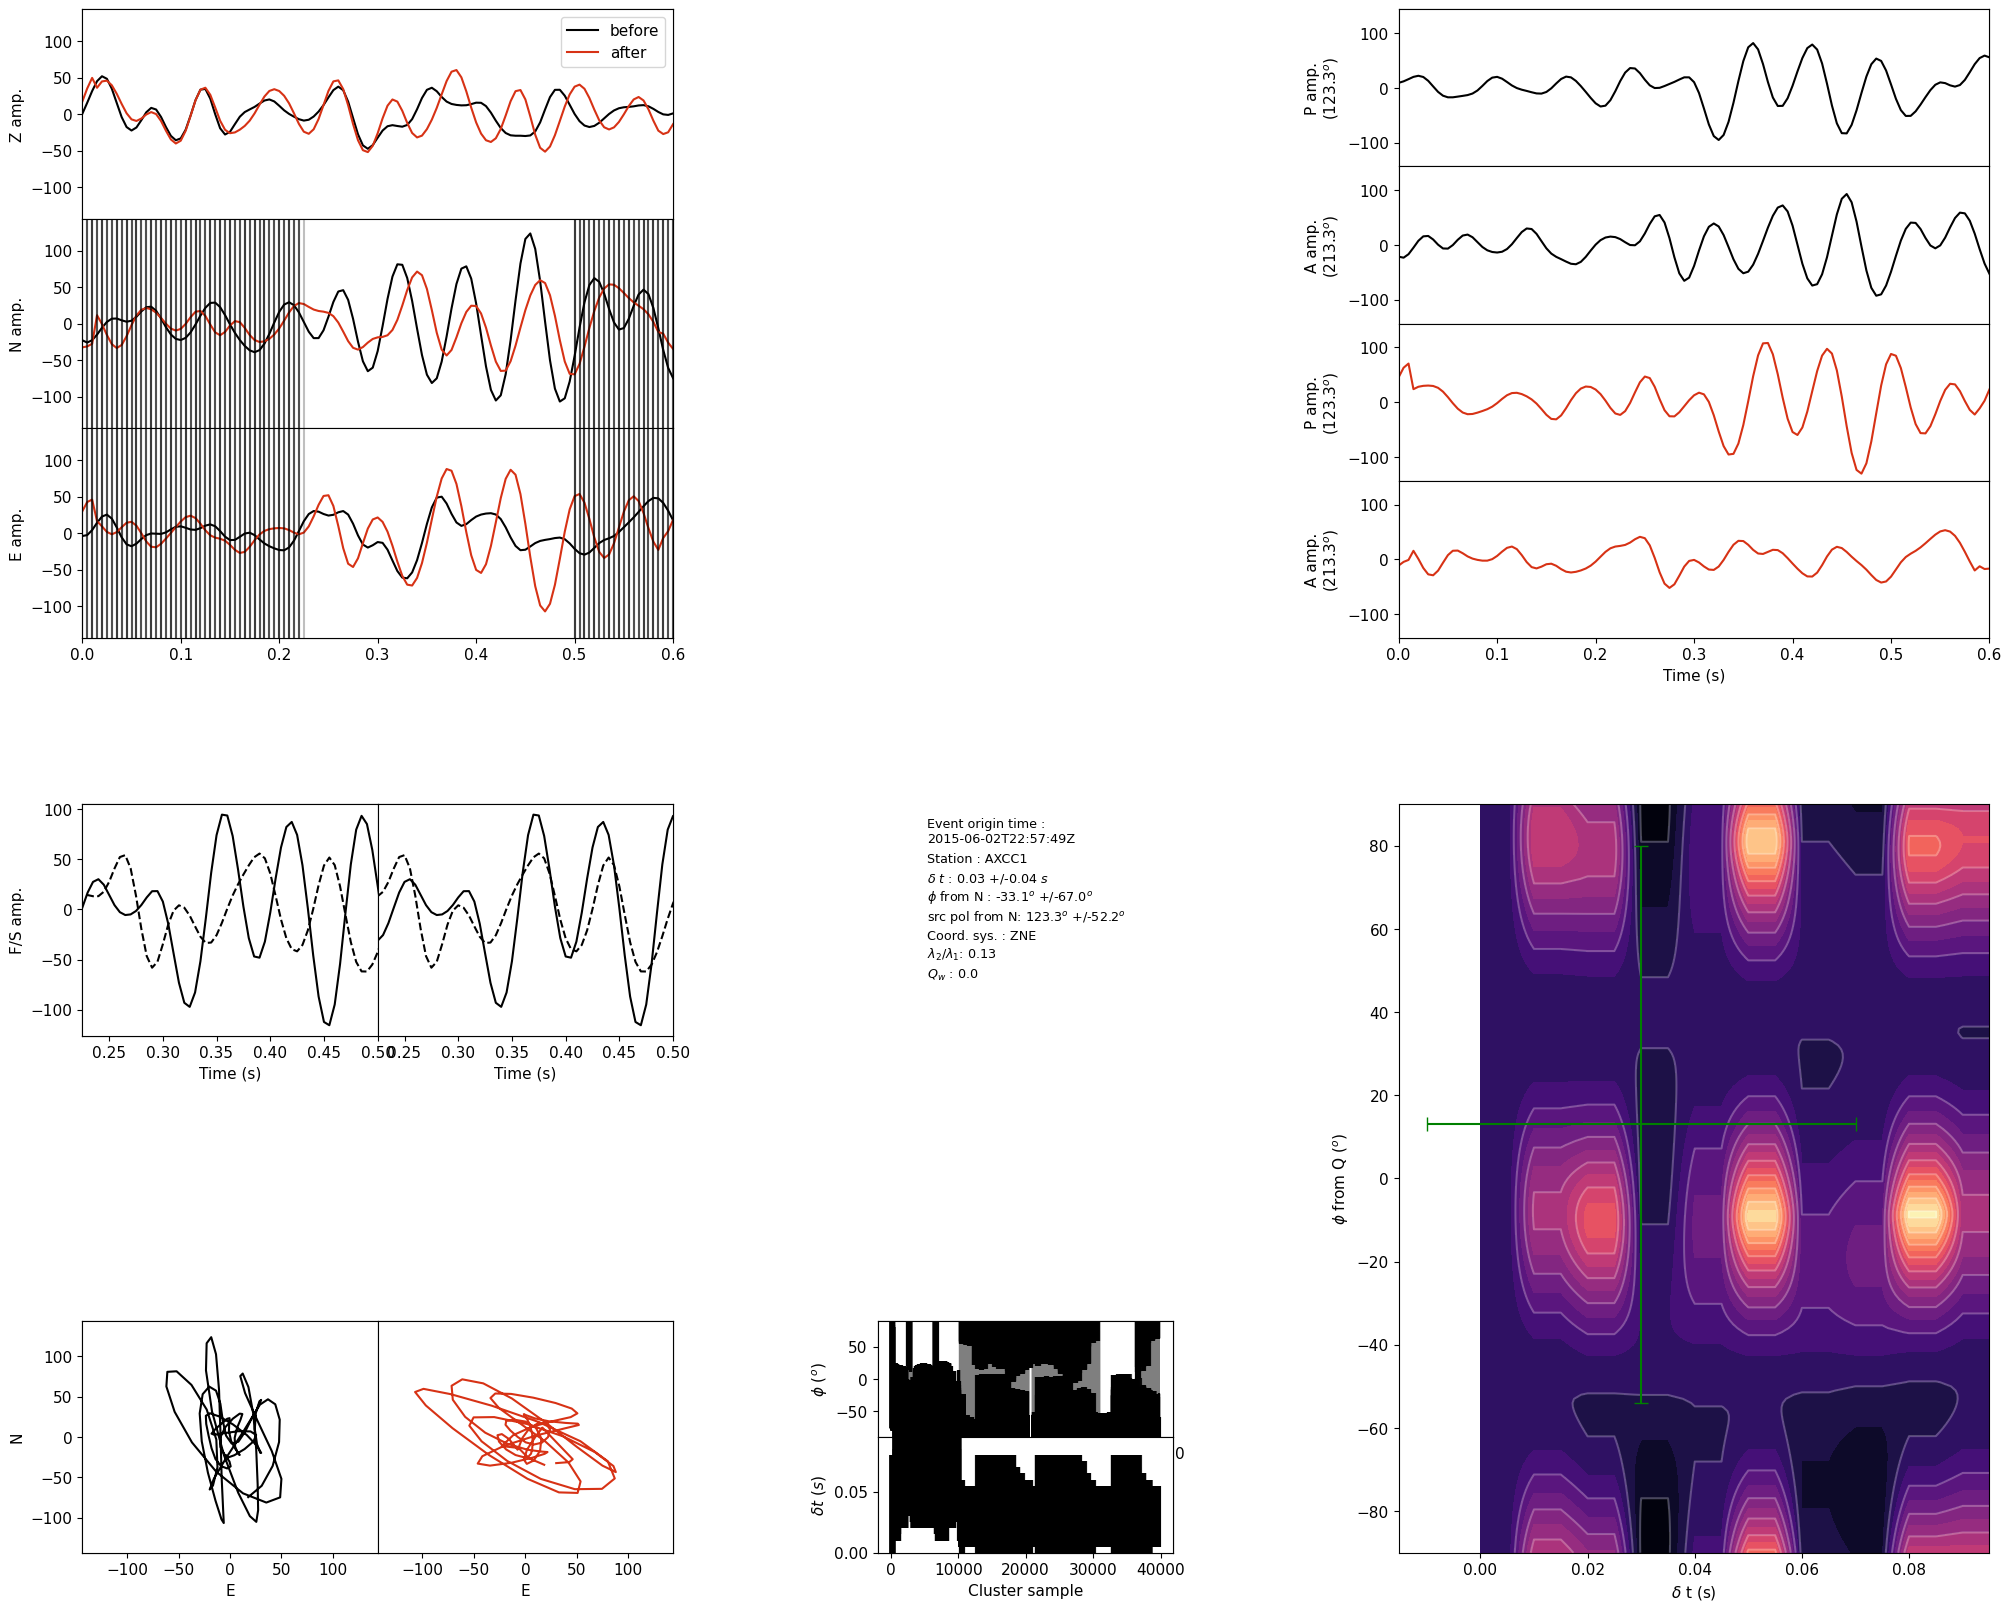

  ✓ Splitting analysis complete!
    Fast axis (φ): -33.1°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): -33.1°
    Delay time (δt): 0.030s
    φ error: ±67.0°
    δt error: ±0.040s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 163
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 302.47°
  Station: AXEC2
  Magnitude: 0.0
  SNR: 2.96
  Rectilinearity: 0.980
  Incidence: 28.5°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-2

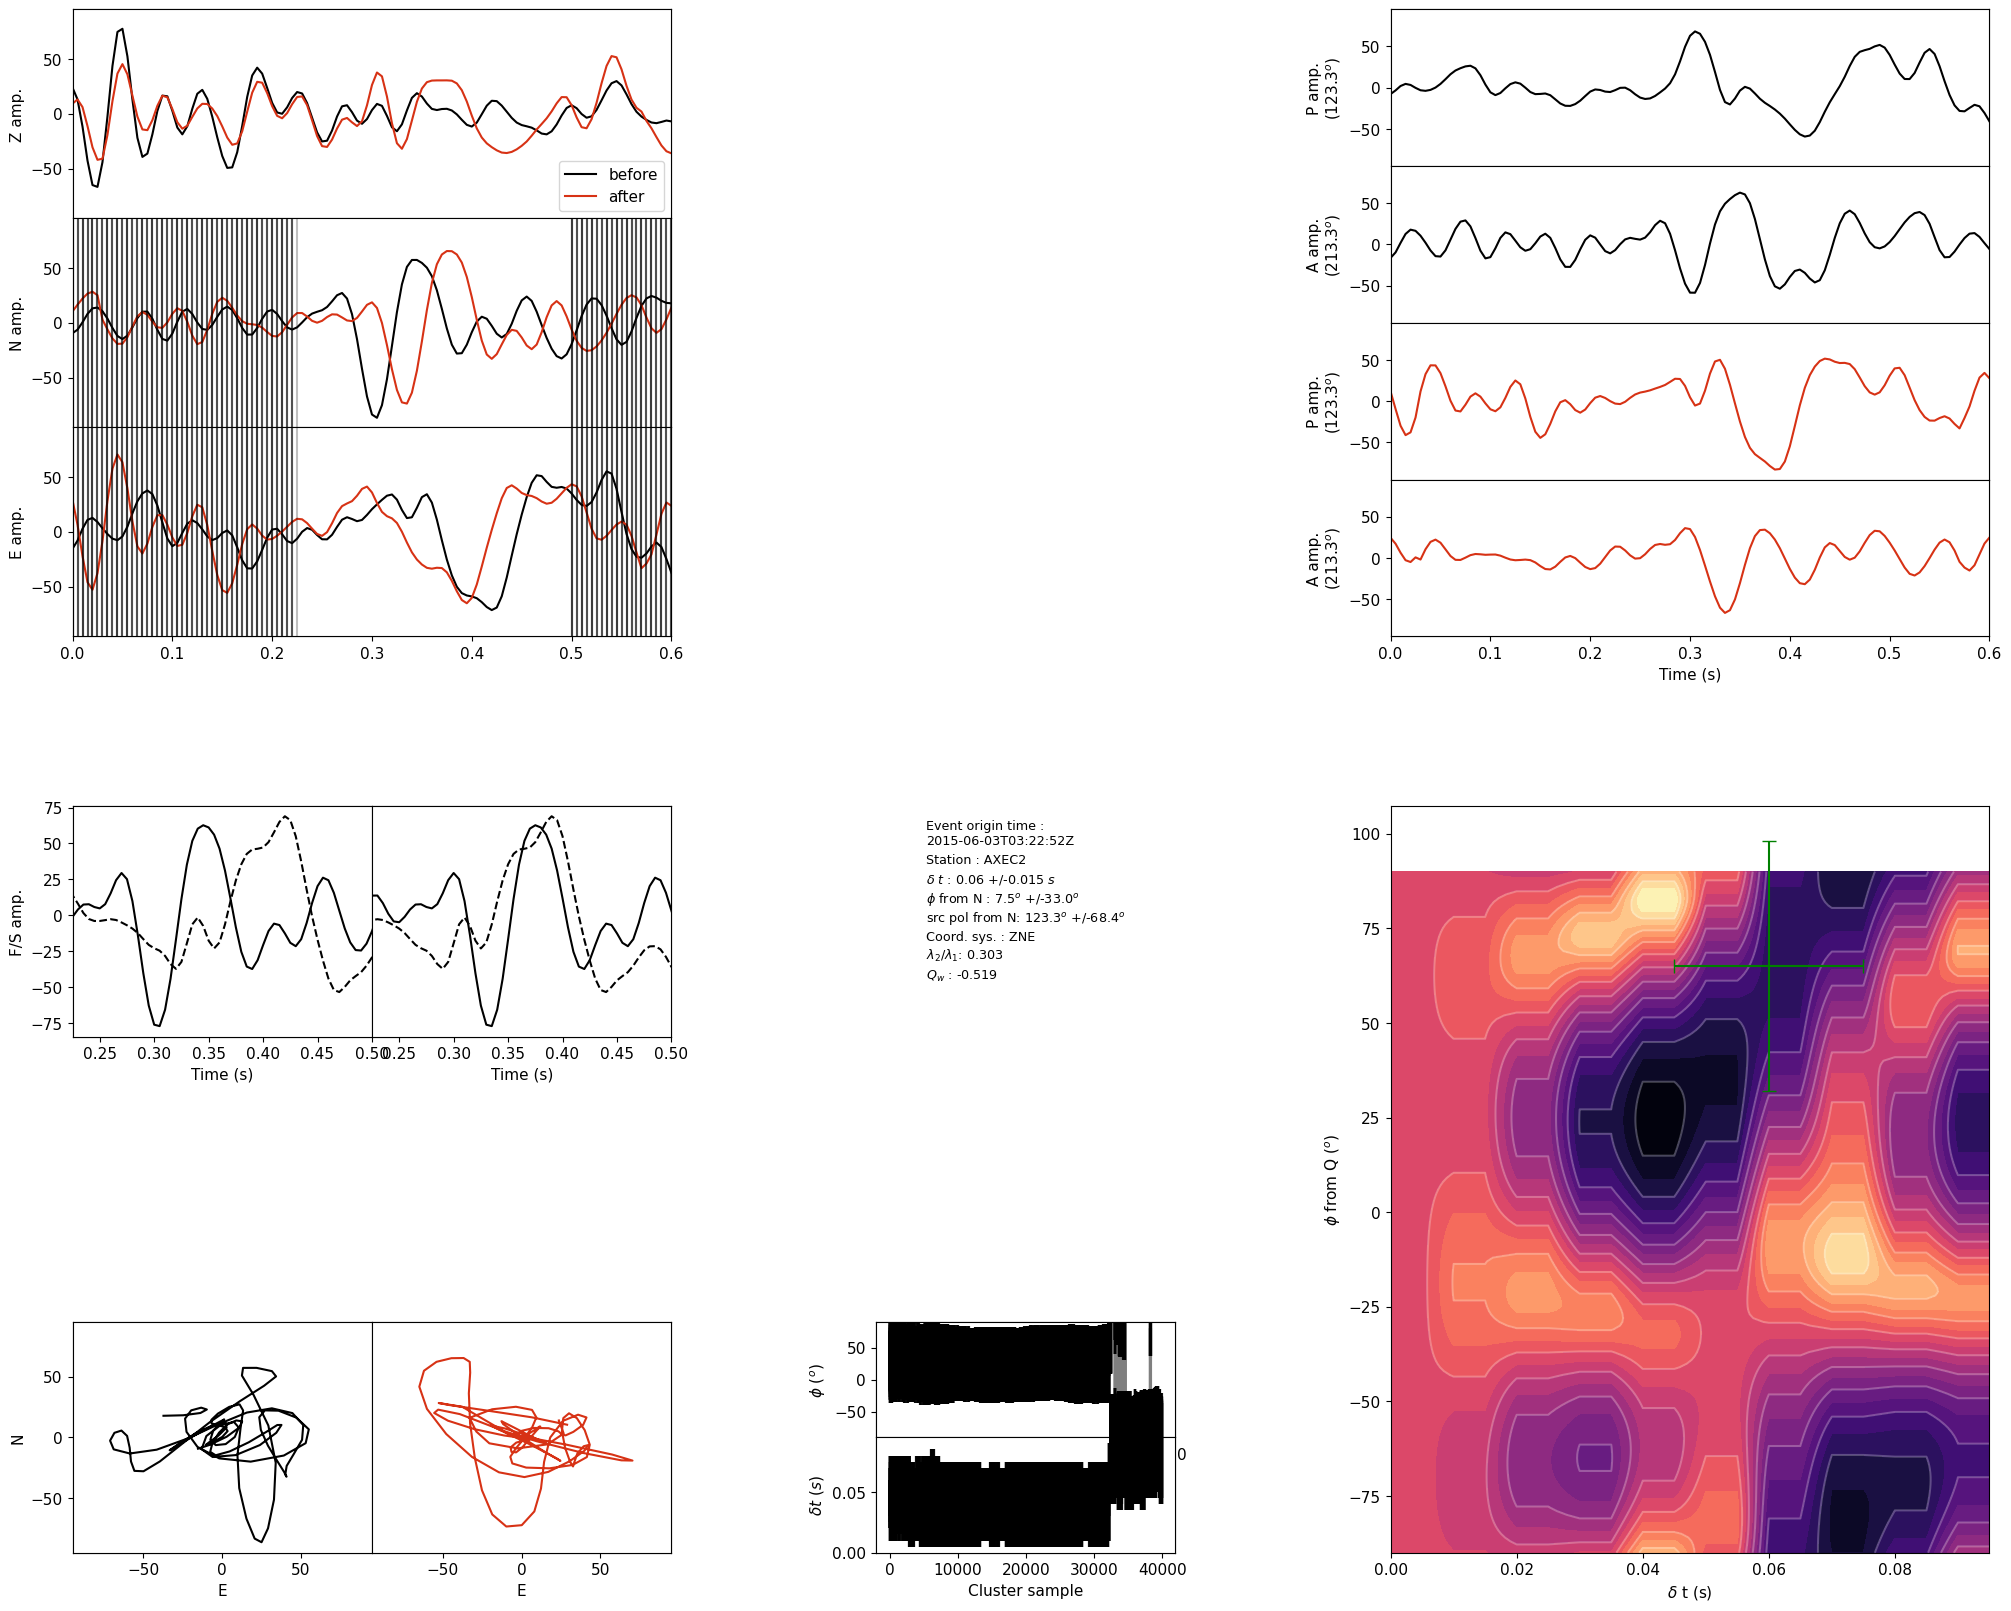

  ✓ Splitting analysis complete!
    Fast axis (φ): 7.5°
    Delay time (δt): 0.060s
  ✓ SUCCESS!
    Fast axis (φ): 7.5°
    Delay time (δt): 0.060s
    φ error: ±33.0°
    δt error: ±0.015s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 173
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 35.80°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.83
  Rectilinearity: 0.865
  Incidence: 21.1°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0 H

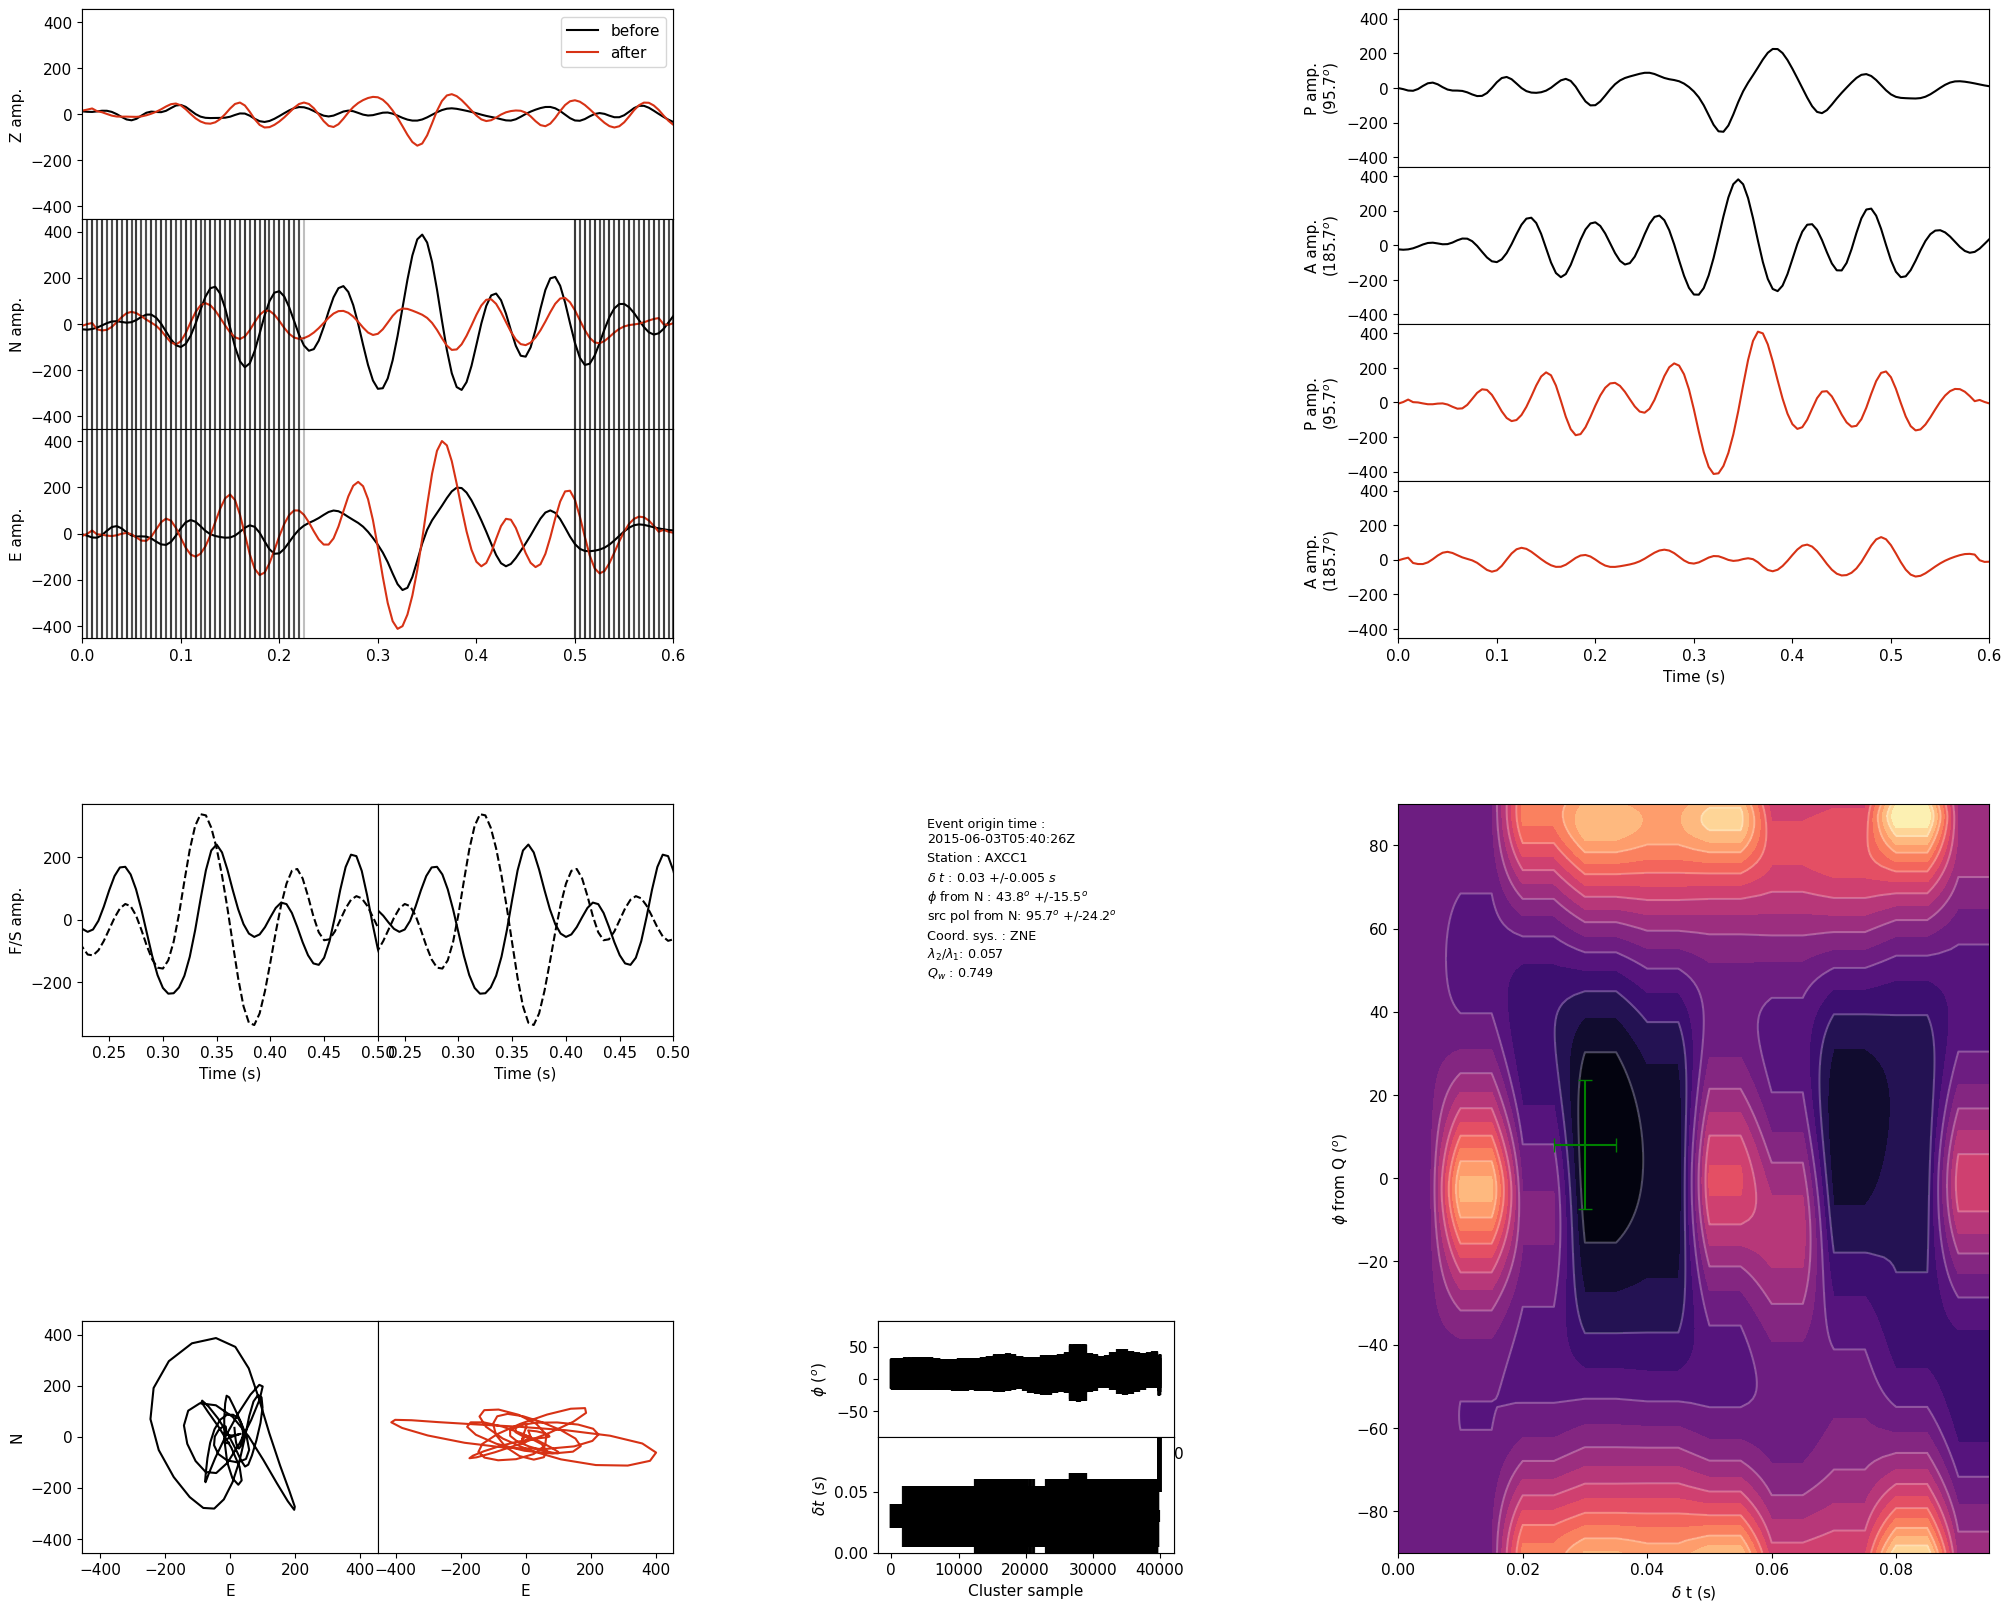

  ✓ Splitting analysis complete!
    Fast axis (φ): 43.8°
    Delay time (δt): 0.030s
  ✓ SUCCESS!
    Fast axis (φ): 43.8°
    Delay time (δt): 0.030s
    φ error: ±15.5°
    δt error: ±0.005s
    Dominant period: 0.100s

────────────────────────────────────────────────────────────
Event 205
────────────────────────────────────────────────────────────
  ✓ Found horizontal components
  ✓ Back-azimuth: 49.87°
  Station: AXCC1
  Magnitude: 0.0
  SNR: 2.77
  Rectilinearity: 0.796
  Incidence: 27.6°

  → Running splitting analysis with dynamic parameters...
  Creating SWSPy splitting object with dynamic parameters...
  Calculating dynamic parameters...
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
Error estimating dominant period: PPSD.__init__() missing 1 required positional argument: 'metadata'
    Dominant period: 0.100 s
    Dynamic window length: 0.500 s
    Optimal frequency range: 5.0-25.0 Hz
  Applying bandpass filter: 5.0-25.0

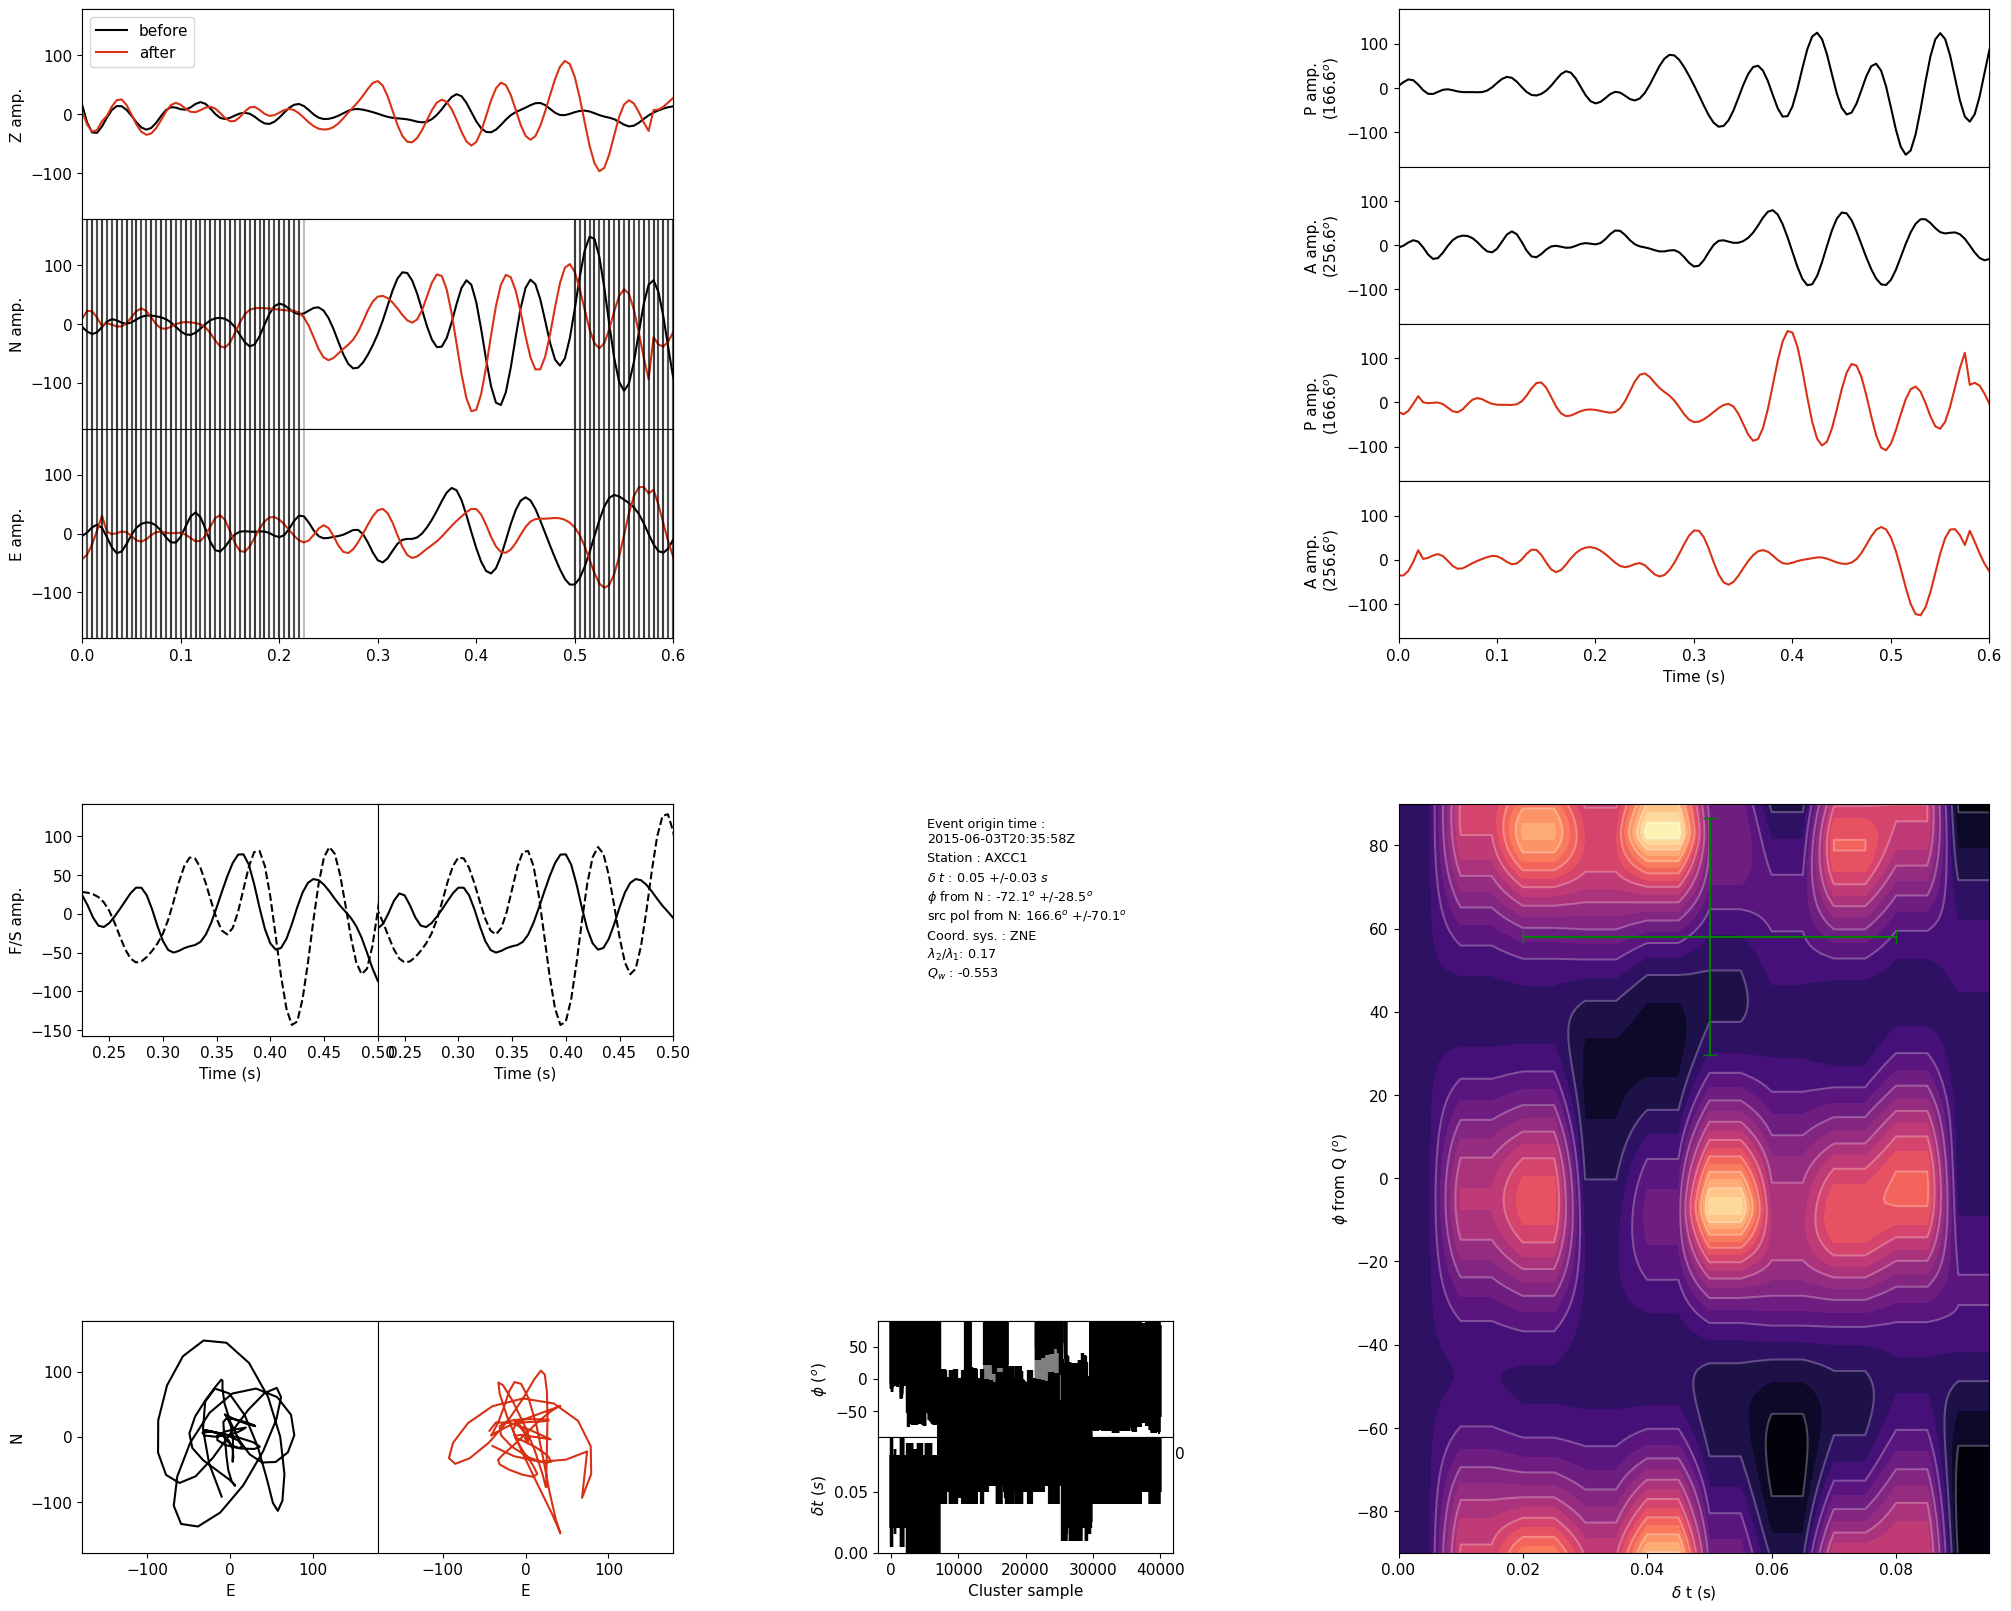

  ✓ Splitting analysis complete!
    Fast axis (φ): -72.1°
    Delay time (δt): 0.050s
  ✓ SUCCESS!
    Fast axis (φ): -72.1°
    Delay time (δt): 0.050s
    φ error: ±28.5°
    δt error: ±0.030s
    Dominant period: 0.100s

Splitting Analysis Summary
Total events processed: 10
Successful splits: 10 (100.0%)

Failure breakdown:
  Missing components: 0
  Missing back-azimuth: 0
  Splitting errors: 0

────────────────────────────────────────────────────────────
Splitting Parameter Statistics
────────────────────────────────────────────────────────────
Fast axis direction (φ):
  Mean: 16.1° ± 45.9°
  Range: -72.1° to 84.6°
  Median: 6.5°

Delay time (δt):
  Mean: 0.046 ± 0.022s
  Range: 0.020s to 0.090s
  Median: 0.040s


In [13]:
# Shear-wave splitting analysis using dynamic splitting parameters
print("Performing shear-wave splitting analysis using SWSPy...")
#results = perform_splitting_on_organized_waveforms(passing_waveforms)

results = perform_splitting_on_organized_waveforms(passing_waveforms)

## 5. Splitting Intensity Calculation

Compute SI from rotated components following Chevrot (2000) formulation.

- Rotate to radial-transverse frame using back-azimuth
- Compute energy ratio: SI = E_T / (E_R + E_T)
- Aggregate SI and uncertainties per event-station pair

In [12]:
# Create results dataframe with splitting parameters
print("Creating results dataframe from splitting analysis...")

# Initialize lists to store results
event_ids = []
datetimes = []
phi_values = []
phi_errors = []
dt_values = []
dt_errors = []

# Extract results from the splitting analysis
for event_id, result_data in results.items():
    if 'result' in result_data and result_data['result'] is not None:
        result = result_data['result']
        
        # Get datetime from passing_waveforms
        if event_id in passing_waveforms:
            datetime_str = passing_waveforms[event_id]['datetime']
            
            event_ids.append(event_id)
            datetimes.append(datetime_str)
            phi_values.append(result.get('phi', np.nan))
            phi_errors.append(result.get('phi_error', np.nan))
            dt_values.append(result.get('dt', np.nan))
            dt_errors.append(result.get('dt_error', np.nan))

# Create dataframe
results_df = pd.DataFrame({
    'event_id': event_ids,
    'datetime': datetimes,
    'phi_from_N': phi_values,
    'phi_error': phi_errors,
    'dt': dt_values,
    'dt_error': dt_errors
})

# Convert datetime strings to datetime objects
results_df['datetime'] = pd.to_datetime(results_df['datetime'])

print(f"Created results dataframe with {len(results_df)} measurements")
print("\nSample results:")
display(results_df.head())

Creating results dataframe from splitting analysis...


NameError: name 'results' is not defined

In [30]:
# Show sample results
sample_event = list(results.keys())[0]
sample_result = results[sample_event]['result']  # Access the 'result' key
print(f"\nSample results for event {sample_event}:")
print(f"  {sample_result['station']}: φ={sample_result['phi']:.1f}°, δt={sample_result['dt']:.3f}s")


Sample results for event 22:
  AXCC1: φ=84.6°, δt=0.060s


In [ ]:
# Results analysis and visualization

# Process results directly from the results dictionary
results_compiled_df = compile_results_dataframe(results, extended_catalog)

results_output_path = '../results/splitting_tomography_results.csv'
results_compiled_df.to_csv(results_output_path, index=False)
print(f"\nResults saved to: {results_output_path}")

In [ ]:
results_compiled_df = pd.read_csv('../results/splitting_tomography_results.csv')

## 7. Global Inversion Setup

Prepare observations and initialize the global linear least-squares inverter.

- Initialize GlobalAnisotropyInverter with velocity model
- Prepare splitting observations (φ, δt) with ray paths
- Prepare SI observations with ray paths
- Set regularization parameters (smoothing + damping)

In [13]:
# Create velocity model
vm = AxialVelocityModel(
    nx=51, ny=51, nz=26,
    x_range=(-5.0, 5.0),
    y_range=(-5.0, 5.0),
    z_range=(0.0, 5.0)
)

# Build velocity model with geological features
velocity = vm.create_model(
    v0_seafloor=2.0,
    velocity_gradient=0.3,
    caldera_center=(0.0, 0.0),
    caldera_width=3.0,
    caldera_length=8.0,
    caldera_angle=15.0,
    magma_chamber_depth=(1.1, 2.3),
    mmr_east_offset=0.7
)

print(f"✓ Velocity model created")
print(f"  Grid: {vm.nx} × {vm.ny} × {vm.nz}")
print(f"  Velocity range: {velocity.min():.2f} - {velocity.max():.2f} km/s")

# Initialize ray tracer
ray_tracer = RayTracer(vm)
print(f"\n✓ Ray tracer initialized")

✓ Velocity model created
  Grid: 51 × 51 × 26
  Velocity range: -0.02 - 3.37 km/s

✓ Initial anisotropic model created
  Percent anisotropy: 1.2 - 6.5%
  Fast direction range: 0.1° - 179.9°

✓ Ray tracer initialized


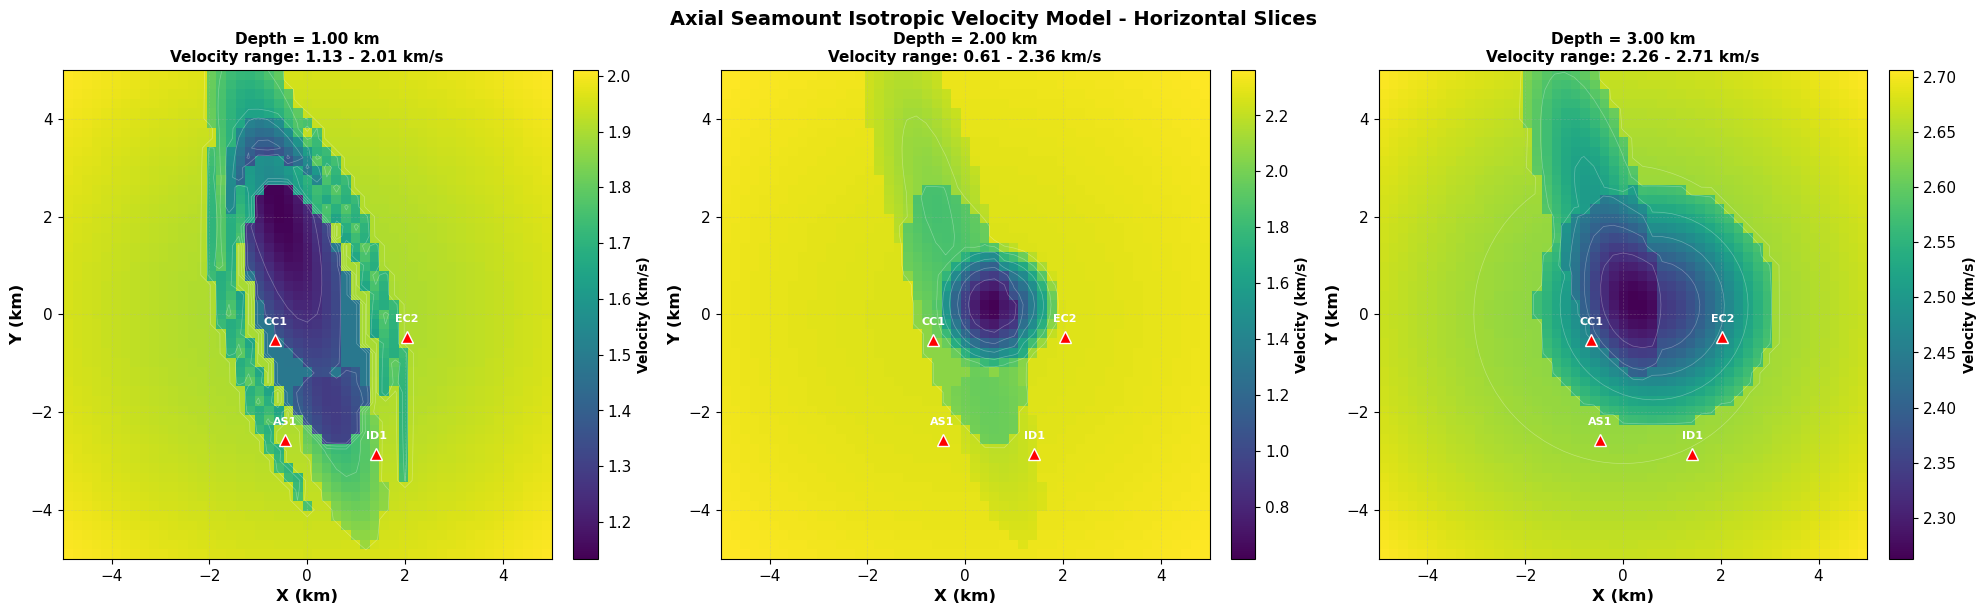

✓ Velocity model plotted at depths:
  1.0 km (actual: 1.000 km)
  2.0 km (actual: 2.000 km)
  3.0 km (actual: 3.000 km)


In [106]:
# Plot the Axial isotropic velocity model at three depth slices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Select three depth levels: 1 km, 2 km, 3 km
target_depths = [1.0, 2.0, 3.0]
depth_indices = []

# Find the closest depth indices
for target_depth in target_depths:
    idx = np.argmin(np.abs(vm.z - target_depth))
    depth_indices.append(idx)
    
# Plot each depth slice
for i, depth_idx in enumerate(depth_indices):
    ax = axes[i]
    
    # Extract velocity slice at this depth
    vel_slice = velocity[:, :, depth_idx]
    
    # Create the image
    im = ax.imshow(vel_slice.T, origin='lower', cmap='viridis',
                   extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                   aspect='equal')
    
    # Add contour lines for better visualization
    contour_levels = np.linspace(vel_slice.min(), vel_slice.max(), 8)
    contours = ax.contour(vm.x, vm.y, vel_slice.T, levels=contour_levels,
                          colors='white', alpha=0.3, linewidths=0.5)
    
    # Labels and title
    ax.set_xlabel('X (km)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Y (km)', fontweight='bold', fontsize=12)
    ax.set_title(f'Depth = {vm.z[depth_idx]:.2f} km\nVelocity range: {vel_slice.min():.2f} - {vel_slice.max():.2f} km/s',
                fontweight='bold', fontsize=11)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Velocity (km/s)', fontweight='bold', fontsize=10)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # Mark station locations if available
    if 'station_df' in locals():
        for _, station in station_df.iterrows():
            ax.plot(station['x_km'], station['y_km'], 'r^', 
                   markersize=8, markeredgecolor='white', markeredgewidth=1)
            ax.text(station['x_km'], station['y_km'] + 0.3, 
                   station['station'].replace('AXIAL', '').replace('AX', ''),
                   fontsize=8, ha='center', color='white', 
                   fontweight='bold')

# Overall title
fig.suptitle('Axial Seamount Isotropic Velocity Model - Horizontal Slices',
            fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('../figures/velocity_model_depth_slices.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Velocity model plotted at depths:")
for i, depth_idx in enumerate(depth_indices):
    print(f"  {target_depths[i]} km (actual: {vm.z[depth_idx]:.3f} km)")

In [14]:
obs_array = OBSArray()
station_df = obs_array.get_station_dataframe()
AXIAL_LAT, AXIAL_LON = 45.9540, -130.0088

In [ ]:
#results_compiled_df['event_id'] = [22, 41, 45, 52, 121, 147, 149, 163, 173, 205]

In [16]:
# Remove the 'event_id' index level from results_compiled_df
results_compiled_df = results_compiled_df.reset_index(drop=True)

print(f"✓ Index reset for results_compiled_df")
print(f"  Shape: {results_compiled_df.shape}")
print(f"  Index type: {type(results_compiled_df.index)}")
print("\nFirst few rows:")
display(results_compiled_df.head())

✓ Index reset for results_compiled_df
  Shape: (10, 16)
  Index type: <class 'pandas.core.indexes.range.RangeIndex'>

First few rows:


event_id station        phi    dt  phi_error  dt_error   avg_snr  \
0        22   AXCC1  84.562724  0.06       17.0     0.035  3.783436   
1        41   AXCC1   2.110829  0.02       20.5     0.010  3.017074   
2        45   AXAS1   5.632551  0.09       14.5     0.005  2.376653   
3        52   AXCC1  74.976188  0.02       17.0     0.010  4.941380   
4       121   AXCC1  50.772814  0.03       13.0     0.005  2.895081   

   magnitude  event_lat  event_lon  event_depth  window_duration  quality  \
0        0.0    45.9487  -129.9862         1.11              0.5  unknown   
1        0.0    45.9173  -129.9840         0.01              0.5  unknown   
2        0.0    45.9435  -129.9823         1.34              0.5  unknown   
3        0.0    45.9540  -129.9915         1.38              0.5  unknown   
4        0.0    45.9515  -129.9940         0.84              0.5  unknown   

   back_azimuth  rectilinearity  incidence  
0    112.562724        0.967455  21.990016  
1    156.110829        0.799946  22.781181  
2     70.632551        0.928851  18.112676  
3     94.976188        0.981996  11.783334  
4    109.772814        0.979005  14.009647

In [19]:
# ============================================================================
# STEP 2: Prepare observed splitting measurements from results
# ============================================================================
print("\n" + "="*80)
print("STEP 2: Preparing observed splitting measurements")
print("="*80)

# Filter out NaN values and ensure we have valid predictions
valid_results = results_with_predictions.dropna(subset=['phi', 'dt', 'predicted_phi', 'predicted_dt']).copy()


# Extract arrays from valid results
observed_phi = valid_results['phi'].values          # Fast directions (degrees)
observed_dt = valid_results['dt'].values            # Delay times (seconds)
observed_phi_error = valid_results['phi_error'].values
observed_dt_error = valid_results['dt_error'].values

# Convert event locations to model coordinates
event_locations = []
for _, row in valid_results.iterrows():
    event_x = (row['event_lon'] - AXIAL_LON) * 111.0 * np.cos(np.radians(row['event_lat']))
    event_y = (row['event_lat'] - AXIAL_LAT) * 111.0
    event_z = row['event_depth']
    event_locations.append([event_x, event_y, event_z])

event_locations = np.array(event_locations)

# Get station locations from station_df
station_locations = []
for _, row in valid_results.iterrows():
    station_info = station_df[station_df['station'] == row['station']].iloc[0]
    station_x = station_info['x_km']
    station_y = station_info['y_km']
    station_z = abs(station_info['z_km'])
    station_locations.append([station_x, station_y, station_z])

station_locations = np.array(station_locations)

print(f"Prepared {len(observed_phi)} splitting measurements for optimization")
print(f"  φ range: {np.nanmin(observed_phi):.1f}° - {np.nanmax(observed_phi):.1f}°")
print(f"  δt range: {np.nanmin(observed_dt):.4f} - {np.nanmax(observed_dt):.4f} s")
print(f"  Event locations range:")
print(f"    X: {event_locations[:, 0].min():.2f} to {event_locations[:, 0].max():.2f} km")
print(f"    Y: {event_locations[:, 1].min():.2f} to {event_locations[:, 1].max():.2f} km")
print(f"    Z: {event_locations[:, 2].min():.2f} to {event_locations[:, 2].max():.2f} km")


STEP 2: Preparing observed splitting measurements
Prepared 10 splitting measurements for optimization
  φ range: -72.1° - 84.6°
  δt range: 0.0200 - 0.0900 s
  Event locations range:
    X: 0.89 to 2.05 km
    Y: -4.07 to 1.59 km
    Z: 0.01 to 2.32 km


Calculating splitting intensity for one example waveform...
Selected event ID: {example_event_id}
Station: {example_data['station']}
Event time: {example_data['datetime']}
SNR: {example_data.get('snr', 'N/A'):.2f}
Back azimuth: {example_data.get('back_azimuth', 'N/A'):.1f}°

✓ Splitting Intensity Calculation Results:
  SI value: 0.0026
  SI uncertainty: 0.0017
  Quality control passed: True


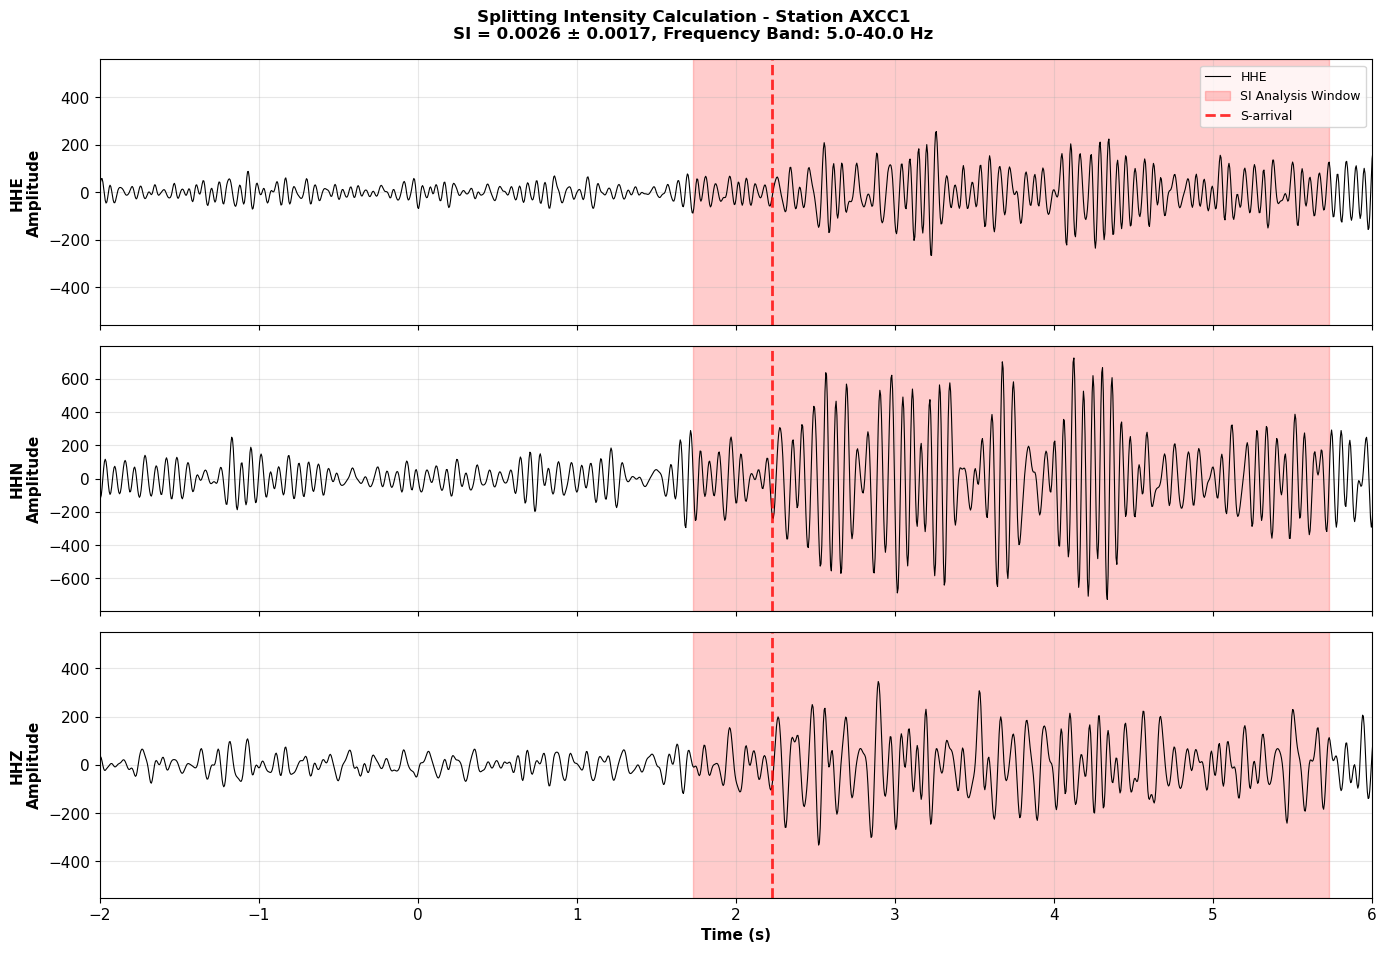


🔬 Splitting Intensity Analysis:
  Method: Chevrot (2000) - Energy ratio on transverse component
  SI = E_T / (E_R + E_T) where E_T, E_R are transverse and radial energies
  Analysis window: 4.0 s after S-arrival
  Frequency band: 5.0-40.0 Hz
  Interpretation: Weak or no anisotropy indicated

✓ Single splitting intensity calculation complete


In [ ]:
# Calculate splitting intensity for one example waveform
print("Calculating splitting intensity for one example waveform...")

# Select an example from organized waveforms that passed quality control
example_event_id = 41  # AXEC2 station with good quality metrics
example_data = passing_waveforms[example_event_id]

print("Selected event ID: {example_event_id}")

# Get the waveform traces
st = example_data['traces'].copy()

si_calculator = SplittingIntensityCalculator(freq_min = 5.0, freq_max = 40.0,
                 window_length = 4.0, taper_fraction = 0.05)


# Calculate splitting intensity using the SI calculator
si_result = si_calculator.calculate_si_from_stream(
    stream = st,
    s_arrival=UTCDateTime(example_data.get('origin_time')) + example_data.get('s_arrival_time'),
    back_azimuth=example_data.get('back_azimuth')
)

st = st.filter(type="bandpass", freqmin=si_calculator.freq_min, freqmax= 20.0)
st = st.taper(type="hann", max_percentage=0.05)

print(f"\n✓ Splitting Intensity Calculation Results:")
print(f"  SI value: {si_result['SI']:.4f}")
print(f"  SI uncertainty: {si_result['SI_uncertainty']:.4f}")
print(f"  Quality control passed: {si_result['passed_qc']}")

# Plot the components used in SI calculation
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Get S-wave arrival time relative to trace start
s_time_rel = example_data.get('s_arrival_time')

# Plot each component
for i, tr in enumerate(st.sort(['channel'])):
    ax = axes[i]
    
    # Filter for display
    trace_start = st[0].stats.starttime
    origin_time = UTCDateTime(example_data.get('origin_time'))
    time_offset = float(trace_start - origin_time)  # Should be -4.0 seconds
    time = tr.times() + time_offset  # Convert to origin-relative time
    
    # Plot waveform
    ax.plot(time, tr.data, 'k', linewidth=0.8, label=tr.stats.channel)
    ax.set_ylabel(f"{tr.stats.channel}\nAmplitude", fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Highlight S-wave analysis window
    window_start = s_time_rel - 0.5
    window_end = s_time_rel + si_calculator.window_length - 0.5
    ax.axvspan(window_start, window_end, alpha=0.2, color='red', 
                label='SI Analysis Window' if i == 0 else '')
    
    # Add S-wave arrival marker
    ax.axvline(s_time_rel, color='red', linestyle='--', alpha=0.8, 
                linewidth=2, label='S-arrival' if i == 0 else '')
    
    # Set limits and formatting
    ax.set_xlim([-2, 6])
    ylim = np.max(np.abs(tr.data))
    ax.set_ylim([-ylim * 1.1, ylim * 1.1])
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Time (s)', fontweight='bold')

# Title with SI results
title = (f"Splitting Intensity Calculation - Station {example_data['station']}\n"
        f"SI = {si_result['SI']:.4f} ± {si_result['SI_uncertainty']:.4f}, "
        f"Frequency Band: {si_calculator.freq_min}-{si_calculator.freq_max} Hz")

fig.suptitle(title, fontsize=12, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print(f"\n Splitting Intensity Analysis:")
print(f"  Method: Chevrot (2000) - Energy ratio on transverse component")
print(f"  SI = E_T / (E_R + E_T) where E_T, E_R are transverse and radial energies")
print(f"  Analysis window: {si_calculator.window_length} s after S-arrival")
print(f"  Frequency band: {si_calculator.freq_min}-{si_calculator.freq_max} Hz")

# Interpretation
if si_result['SI'] > 0.3:
    interpretation = "Strong anisotropy indicated"
elif si_result['SI'] > 0.1:
    interpretation = "Moderate anisotropy indicated"  
else:
    interpretation = "Weak or no anisotropy indicated"

print(f"  Interpretation: {interpretation}")

print(f"\n✓ Single splitting intensity calculation complete")

In [26]:

print("\\n" + "-"*50)
print("8.1 Initialize Splitting Intensity Calculator")
print("-"*50)

# Initialize SI calculator with appropriate frequency band
si_calculator = SplittingIntensityCalculator(
    freq_min=5.0,  # Match splitting analysis frequency band
    freq_max=40.0,
    window_length=4.0,  # 4-second analysis window
    taper_fraction=0.05
)

print("✓ SI Calculator initialized")
print(f"  Frequency band: {si_calculator.freq_min}-{si_calculator.freq_max} Hz")
print(f"  Analysis window: {si_calculator.window_length} s")

# Calculate SI for organized waveforms
print("\\n" + "-"*50)
print("8.2 Calculate Splitting Intensity")  
print("-"*50)

# Use the organized waveforms from previous analysis
si_results = batch_calculate_si(
    organized_waveforms=passing_waveforms,
    stations_df=stations_df,
    si_calculator=si_calculator,
    quality_control=False
)

# Analyze SI results
valid_si_count = sum(1 for result in si_results.values() if result['passed_qc'])
total_si_count = len(si_results)

print(f"\\n✓ SI calculation complete")
print(f"  Total measurements: {total_si_count}")
print(f"  Passed QC: {valid_si_count} ({valid_si_count/total_si_count*100:.1f}%)")

# Extract SI values for analysis
si_values = []
si_uncertainties = []
si_event_ids = []

for event_id, result in si_results.items():
    if result['passed_qc'] and not np.isnan(result['SI']):
        si_values.append(result['SI'])
        si_uncertainties.append(result['SI_uncertainty']) 
        si_event_ids.append(event_id)

si_values = np.array(si_values)
si_uncertainties = np.array(si_uncertainties)

print(f"\\n✓ Valid SI statistics:")
print(f"  SI range: {si_values.min():.3f} - {si_values.max():.3f}")
print(f"  SI mean: {si_values.mean():.3f} ± {si_values.std():.3f}")
print(f"  Mean uncertainty: {si_uncertainties.mean():.4f}")


\n--------------------------------------------------
8.1 Initialize Splitting Intensity Calculator
--------------------------------------------------
✓ SI Calculator initialized
  Frequency band: 5.0-40.0 Hz
  Analysis window: 4.0 s
\n--------------------------------------------------
8.2 Calculate Splitting Intensity
--------------------------------------------------
\n✓ SI calculation complete
  Total measurements: 10
  Passed QC: 10 (100.0%)
\n✓ Valid SI statistics:
  SI range: -0.007 - 0.011
  SI mean: 0.001 ± 0.004
  Mean uncertainty: 0.0024


## 8. Inversion Execution & Results Visualization

Solve the global least-squares system and visualize the recovered 3D anisotropy structure.

- Execute inversion: (G^T W² G + λ² R^T R) **m** = G^T W² **d**
- Recover anisotropy strength A and fast direction ψ
- Visualize results in 3D and horizontal slices
- Generate diagnostic plots and statistics

In [ ]:
print("\n" + "-"*50)
print("9.1 Setup Global Inversion")
print("-"*50)

# Initialize global inverter with velocity model
from global_anisotropy_inversion import GlobalAnisotropyInverter

# Set up regularization parameters
regularization_params = {
    'lambda_smooth': 1.0,        # Spatial smoothing weight
    'lambda_damp': 0.1,          # Damping weight  
    'smooth_horizontal': 1.0,     # Horizontal smoothing relative weight
    'smooth_vertical': 0.5,       # Vertical smoothing relative weight
}

global_inverter = GlobalAnisotropyInverter(
    velocity_model=vm,
    regularization_params=regularization_params
)

print(f"✓ Global inverter initialized")
print(f"  Grid dimensions: {vm.nx} × {vm.ny} × {vm.nz}")
print(f"  Total cells: {global_inverter.n_cells}")
print(f"  Model parameters: {global_inverter.n_params}")

# Prepare splitting observations for global method
print("\n" + "-"*50)
print("9.2 Prepare Splitting Observations")
print("-"*50)

print(f"Processing {len(results_compiled_df)} splitting measurements...")

# Convert DataFrame results to global inversion format
splitting_observations = []

for _, result in results_compiled_df.iterrows():
    # Get event location - assume we need to convert lat/lon to local coordinates
    # For now, use a simple conversion or assume events are already in local coords
    event_lat, event_lon, event_depth = result['event_lat'], result['event_lon'], result['event_depth']
    
    # Simple conversion assuming the coordinate system is similar to stations
    # You may need to adjust this based on your actual coordinate system
    event_x = (result['event_lon'] - AXIAL_LON) * 111.0 * np.cos(np.radians(result['event_lat']))
    event_y = (result['event_lat'] - AXIAL_LAT) * 111.0
    event_z = result['event_depth']
    event_loc = np.array([event_x, event_y, event_z])
    
    # Get station location from station_df
    station_name = result['station']
    station_info = station_df[station_df['station'] == station_name].iloc[0]
    station_loc = np.array([station_info['x_km'], station_info['y_km'], station_info['z_km']])
    
    # Use ray tracer to get path lengths through each cell
    try:
        ray_path = ray_tracer.compute_ray_path(event_loc, station_loc)
        
        # Convert ray path to cell path lengths
        Lij = {}
        for segment in ray_path:
            cell_i, cell_j, cell_k = segment[0], segment[1], segment[2]
            if (0 <= cell_i < vm.nx and 0 <= cell_j < vm.ny and 0 <= cell_k < vm.nz):
                cell_idx = cell_i * vm.ny * vm.nz + cell_j * vm.nz + cell_k
                Lij[cell_idx] = cell_idx
        
        if len(Lij) > 0:  # Only add if ray passes through grid
            obs = {
                'delta_t': result['dt'],
                'phi': result['phi'],              # Fast direction in degrees
                'azimuth': result['back_azimuth'], # Ray azimuth
                'Lij': Lij,                       # Path lengths through cells
                'sigma_dt': result['dt_error'], # Uncertainty in seconds
                'sigma_phi': result['phi_error']   # Uncertainty in degrees
            }
            splitting_observations.append(obs)
            
    except Exception as e:
        print(f"Warning: Ray tracing failed for event {result.get('event_id', 'unknown')}: {e}")
        continue

print(f"✓ Prepared {len(splitting_observations)} splitting observations with ray paths")

# Add observations to inverter
if len(splitting_observations) > 0:
    global_inverter.add_splitting_observations(splitting_observations)
    print(f"✓ Added splitting observations to inverter")
else:
    print("No valid splitting observations with ray paths!")

# Prepare SI observations if available
print("\n" + "-"*50)
print("9.3 Prepare SI Observations")
print("-"*50)

si_observation_count = 0
if 'si_results' in locals() and len(si_results) > 0:
    print(f"Processing SI results for {len(si_results)} events...")
    
    si_observations = []
    
    for event_id, result in si_results.items():
        if result['passed_qc'] and event_id in organized_waveforms:
            waveform_data = organized_waveforms[event_id]
            
            # Calculate ray path - construct event and station locations from available data
            event_loc = np.array([
                (waveform_data['longitude'] - AXIAL_LON) * 111.00 * np.cos(np.radians(waveform_data['latitude'])),
                (waveform_data['latitude'] - AXIAL_LAT) * 111.00,
                waveform_data['depth']
            ])
            
            # Get station location from station_df
            station_name = waveform_data['station']
            station_info = station_df[station_df['station'] == station_name].iloc[0]
            station_loc = np.array([station_info['x_km'], station_info['y_km'], station_info['z_km']])
            
            try:
                ray_path = ray_tracer.compute_ray_path(event_loc, station_loc)
                
                # Convert ray path to cell path lengths
                Lij = {}
                for segment in ray_path:
                    cell_i, cell_j, cell_k = segment[0], segment[1], segment[2]
                    if (0 <= cell_i < vm.nx and 0 <= cell_j < vm.ny and 0 <= cell_k < vm.nz):
                        cell_idx = cell_i * vm.ny * vm.nz + cell_j * vm.nz + cell_k
                        Lij[cell_idx] = cell_idx
                
                if len(Lij) > 0:
                    obs = {
                        'SI': result['SI'],
                        'azimuth': waveform_data['back_azimuth'],
                        'Lij': Lij,
                        'sigma_si': result['SI_uncertainty'],
                        's_factor': 1.0  # Sensitivity factor
                    }
                    si_observations.append(obs)
                    si_observation_count += 1
                    
            except Exception as e:
                print(f"Warning: Ray tracing failed for SI event {event_id}: {e}")
                continue
    
    if len(si_observations) > 0:
        global_inverter.add_splitting_intensity_observations(si_observations)
        print(f"✓ Added {len(si_observations)} SI observations")
    else:
        print("No valid SI observations with ray paths")


# Summary of observations
print("\n" + "-"*50)
print("9.4 Observation Summary")
print("-"*50)

total_splitting = len(splitting_observations) if 'splitting_observations' in locals() else 0
total_si = si_observation_count

print(f"✓ Total observations prepared:")
print(f"  Splitting measurements: {total_splitting}")
print(f"  SI measurements: {total_si}")
print(f"  Total observations: {total_splitting + total_si}")

if total_splitting + total_si == 0:
    print("\n❌ No observations available for inversion!")
    print("Please ensure ray paths can be calculated through the model grid.")
else:
    print(f"\n✓ Ready for global inversion with {total_splitting + total_si} observations")


--------------------------------------------------
9.1 Setup Global Inversion
--------------------------------------------------
✓ Global inverter initialized
  Grid dimensions: 51 × 51 × 26
  Total cells: 67626
  Model parameters: 135252

--------------------------------------------------
9.2 Prepare Splitting Observations
--------------------------------------------------
Processing 10 splitting measurements...
✓ Prepared 3 splitting observations with ray paths
✓ Added splitting observations to inverter

--------------------------------------------------
9.3 Prepare SI Observations
--------------------------------------------------
Processing SI results for 10 events...
✓ Added 3 SI observations

--------------------------------------------------
9.4 Observation Summary
--------------------------------------------------
✓ Total observations prepared:
  Splitting measurements: 3
  SI measurements: 3
  Total observations: 6

✓ Ready for global inversion with 6 observations


In [28]:

print("\\n" + "-"*50)
print("9.4 Perform Global Inversion")
print("-"*50)

# Solve the global linear least-squares system
print("Solving global linear least-squares system...")

global_result = global_inverter.solve_inversion(lambda_reg = 1.13)

print(f"\n✓ Global inversion complete")


\n--------------------------------------------------
9.4 Perform Global Inversion
--------------------------------------------------
Solving global linear least-squares system...
Building design matrix...
Building regularization matrix...
Building weight matrix...
Assembling normal equations...
System size: 135252 parameters, 9 observations
Matrix sparsity: 0.0%
Solving with spsolve...
Inversion complete!
  RMS weighted residual: 2.444
  Regularization λ: 1.13e+00

✓ Global inversion complete


In [30]:
aniso_structure = global_inverter.get_anisotropy_structure()

Anisotropy structure shapes:
  Strength: (51, 51, 26)
  Fast direction: (51, 51, 26)
  Strength range: -0.000 - 0.029
  Fast direction range: 0.0° - 180.0°


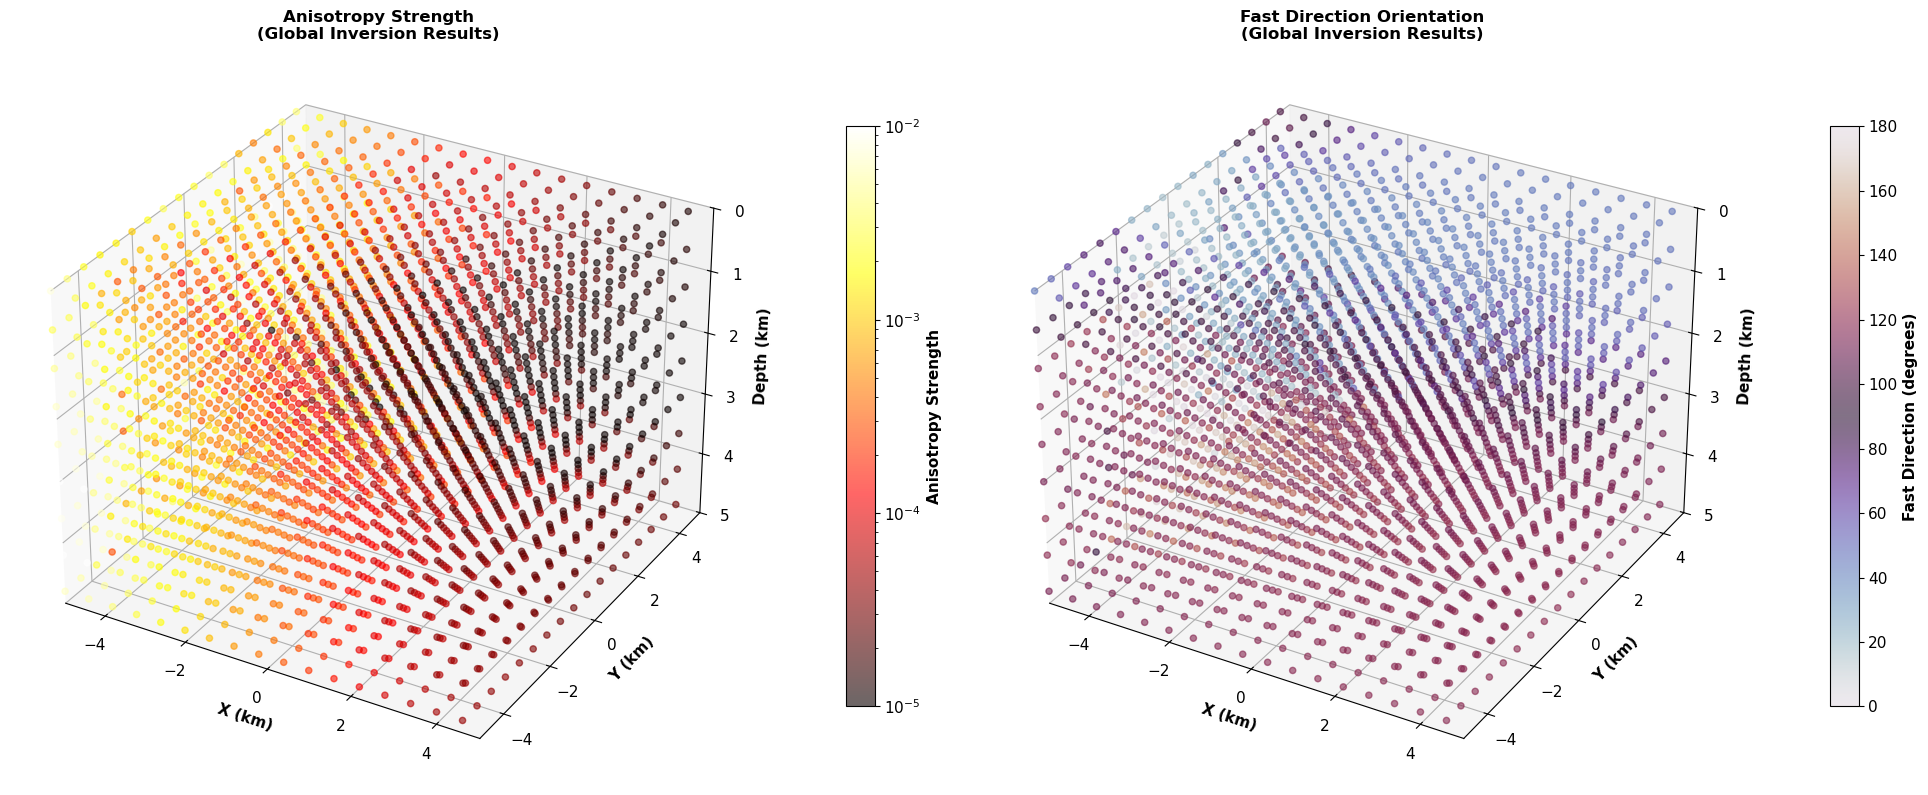

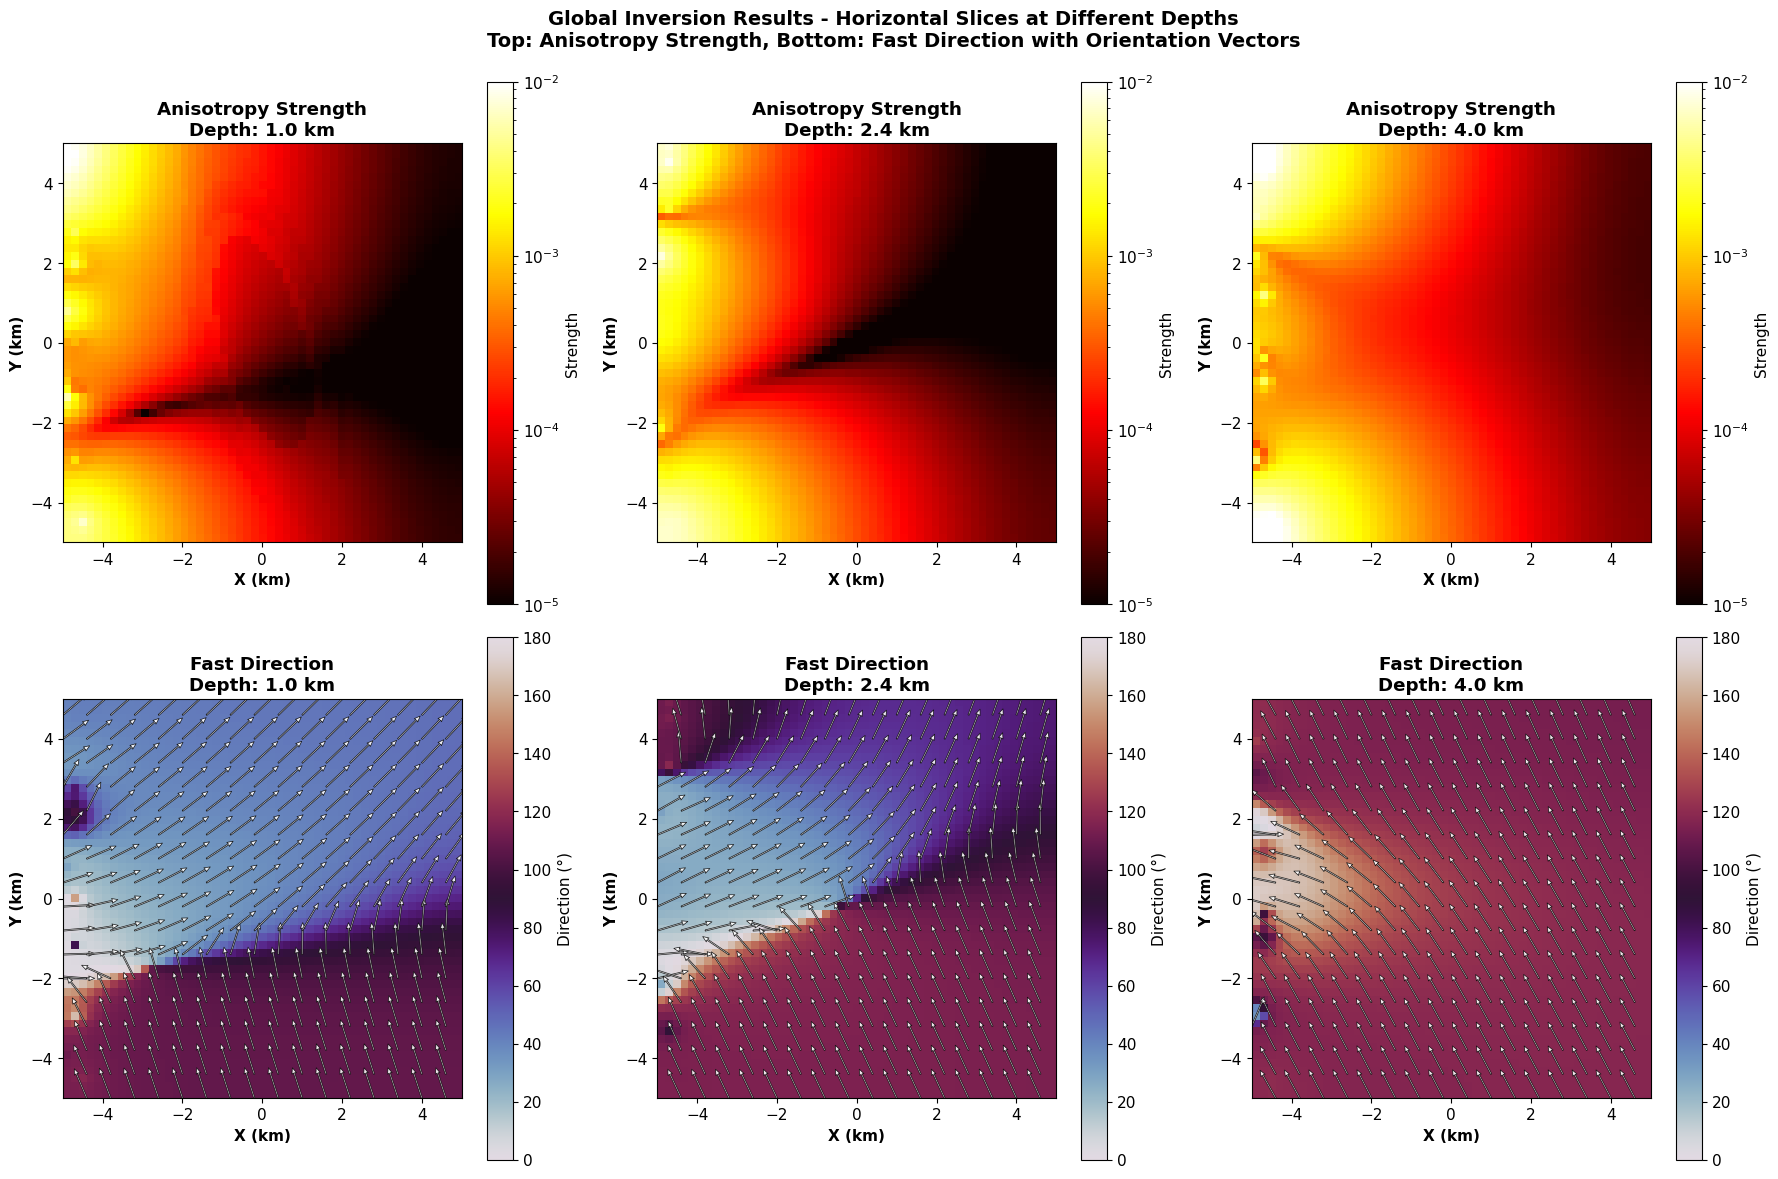

In [99]:
# Plot the anisotropy structure in 3D space
fig = plt.figure(figsize=(20, 10))

# Extract anisotropy strength and fast direction from the tuple
aniso_strength, fast_direction = aniso_structure

velocity = global_inverter.vm.velocity

aniso_strength = aniso_strength * velocity * 1000 * 100.0  # Convert to percentage

print(f"Anisotropy structure shapes:")
print(f"  Strength: {aniso_strength.shape}")
print(f"  Fast direction: {fast_direction.shape}")
print(f"  Strength range: {aniso_strength.min():.3f} - {aniso_strength.max():.3f}")
print(f"  Fast direction range: {fast_direction.min():.1f}° - {fast_direction.max():.1f}°")

# Create meshgrids for 3D plotting
X, Y, Z = np.meshgrid(vm.x, vm.y, vm.z, indexing='ij')

# Plot 1: Anisotropy Strength in 3D
ax1 = fig.add_subplot(121, projection='3d')

# Sample the data for visualization (every 3rd point to avoid overcrowding)
step = 3
X_sample = X[::step, ::step, ::step]
Y_sample = Y[::step, ::step, ::step]
Z_sample = Z[::step, ::step, ::step]
strength_sample = aniso_strength[::step, ::step, ::step]

# Create scatter plot colored by anisotropy strength
scatter1 = ax1.scatter(X_sample.flatten(), Y_sample.flatten(), Z_sample.flatten(),
                      c=strength_sample.flatten(), cmap='hot', s=20, alpha=0.6,
                      norm=mcolors.LogNorm(vmin=1e-5, vmax=1e-2))
ax1.set_xlabel('X (km)', fontweight='bold')
ax1.set_ylabel('Y (km)', fontweight='bold')
ax1.set_zlabel('Depth (km)', fontweight='bold')
ax1.set_title('Anisotropy Strength\n(Global Inversion Results)', fontweight='bold', fontsize=12)
ax1.invert_zaxis()

# Add colorbar
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.6, pad=0.1)
cbar1.set_label('Anisotropy Strength', fontweight='bold')

# Set reasonable viewing limits
ax1.set_xlim([-5, 5])
ax1.set_ylim([-5, 5])
ax1.set_zlim([5, 0])

# Plot 2: Fast Direction in 3D
ax2 = fig.add_subplot(122, projection='3d')

# Sample fast direction data
fast_dir_sample = fast_direction[::step, ::step, ::step]

# Create scatter plot colored by fast direction
scatter2 = ax2.scatter(X_sample.flatten(), Y_sample.flatten(), Z_sample.flatten(),
                      c=fast_dir_sample.flatten(), cmap='twilight', s=20, alpha=0.6,
                      vmin=0, vmax=180)

ax2.set_xlabel('X (km)', fontweight='bold')
ax2.set_ylabel('Y (km)', fontweight='bold')
ax2.set_zlabel('Depth (km)', fontweight='bold')
ax2.set_title('Fast Direction Orientation\n(Global Inversion Results)', fontweight='bold', fontsize=12)
ax2.invert_zaxis()

# Add colorbar
cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.6, pad=0.1)
cbar2.set_label('Fast Direction (degrees)', fontweight='bold')

# Set reasonable viewing limits
ax2.set_xlim([-5, 5])
ax2.set_ylim([-5, 5])
ax2.set_zlim([5, 0])

plt.tight_layout()
plt.savefig('../figures/anisotropy_structure_3d.png', dpi=150, bbox_inches='tight')
plt.show()

# Create additional horizontal slices at different depths
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Select three depth levels for detailed view
depth_indices = [5, 12, 20]  # Shallow, middle, deep
depth_values = [vm.z[i] for i in depth_indices]

for i, depth_idx in enumerate(depth_indices):
    # Anisotropy strength slice
    ax_strength = axes[0, i]
    strength_slice = aniso_strength[:, :, depth_idx]
    im1 = ax_strength.imshow(strength_slice.T, origin='lower', cmap='hot', 
                           extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                           norm=mcolors.LogNorm(vmin=1e-5, vmax=1e-2),aspect='equal')
    ax_strength.set_xlabel('X (km)', fontweight='bold')
    ax_strength.set_ylabel('Y (km)', fontweight='bold')
    ax_strength.set_title(f'Anisotropy Strength\nDepth: {depth_values[i]:.1f} km', fontweight='bold')
    plt.colorbar(im1, ax=ax_strength, label='Strength')
    
    # Fast direction slice
    ax_fast = axes[1, i]
    fast_slice = fast_direction[:, :, depth_idx]
    im2 = ax_fast.imshow(fast_slice.T, origin='lower', cmap='twilight',
                        extent=[vm.x_min, vm.x_max, vm.y_min, vm.y_max],
                        vmin=0, vmax=180, aspect='equal')
    ax_fast.set_xlabel('X (km)', fontweight='bold')
    ax_fast.set_ylabel('Y (km)', fontweight='bold')
    ax_fast.set_title(f'Fast Direction\nDepth: {depth_values[i]:.1f} km', fontweight='bold')
    plt.colorbar(im2, ax=ax_fast, label='Direction (°)')
    
    # Add vector field overlay for fast directions (sample every 3rd point)
    x_vec = vm.x[::3]
    y_vec = vm.y[::3]
    X_vec, Y_vec = np.meshgrid(x_vec, y_vec, indexing='ij')
    
    # Sample fast directions and convert to unit vectors
    fast_sample = fast_direction[::3, ::3, depth_idx]
    strength_sample = aniso_strength[::3, ::3, depth_idx]
    
    # Normalize strength for vector scaling (avoid extreme values)
    strength_normalized = np.log10(strength_sample + 1e-15) + 15  # Shift to positive range
    strength_normalized = np.clip(strength_normalized, 0, 5) / 5.0  # Normalize to [0, 1]
    
    # Convert angles to vectors (scale by normalized anisotropy strength)
    phi_rad = np.radians(fast_sample)
    u_vec = np.cos(phi_rad) * strength_normalized * 0.8  # Scale factor for visibility
    v_vec = np.sin(phi_rad) * strength_normalized * 0.8
    
    # Plot vector field with better styling
    ax_fast.quiver(X_vec, Y_vec, u_vec, v_vec, angles='xy', scale_units='xy', 
                  scale=1, color='white', alpha=0.9, width=0.003, 
                  headwidth=4, headlength=5, headaxislength=4.5,
                  edgecolor='black', linewidth=0.5)

# Add overall title
fig.suptitle('Global Inversion Results - Horizontal Slices at Different Depths\n'
            'Top: Anisotropy Strength, Bottom: Fast Direction with Orientation Vectors',
            fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('../figures/anisotropy_structure_slices.png', dpi=150, bbox_inches='tight')
plt.show()
